In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from scipy.integrate import solve_ivp


In [3]:
def plot_wigners(states, xvec=None, figsize=(6,6), titles=None, cmap="RdBu_r"):
    """
    Plot Wigner functions for one or more states.

    Parameters
    ----------
    states : Qobj or list of Qobj
        A single state or list of states (ket or density matrix).
    xvec : array_like, optional
        Phase-space grid over which to compute the Wigner function.
        If None, defaults to np.linspace(-5,5,200).
    figsize : tuple, optional
        Figure size for matplotlib.
    titles : list of str, optional
        Titles for each subplot. If None, uses index-based titles.
    cmap : str or Colormap, optional
        Matplotlib colormap for the Wigner plot.
    """
    # Ensure we have a list
    if not isinstance(states, (list, tuple)):
        states = [states]
    n = len(states)

    # Default phase-space grid
    if xvec is None:
        xvec = np.linspace(-5, 5, 200)

    # Titles
    if titles is None:
        titles = [f"State {i+1}" for i in range(n)]

    # Create subplots
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]))
    if n == 1:
        axes = [axes]

    for ax, rho, title in zip(axes, states, titles):
        # If pure ket, convert to density matrix
        if rho.isket:
            rho = rho * rho.dag()

        # Compute Wigner
        W = qt.wigner(rho, xvec, xvec)

        # Plot
        im = ax.contourf(xvec, xvec, W, 100, cmap=cmap)
        ax.set_title(title)
        ax.set_xlabel('Re(α)')
        ax.set_ylabel('Im(α)')
        ax.set_aspect('equal')

    # Colorbar
    fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, label='Wigner W')

    plt.tight_layout()
    plt.show()


In [4]:
def plot_1sigma_contours(states, a, labels=None, scale=1.0, figsize=(6,6), legend=False, title=None):
    """
    Plot the 1-sigma Gaussian contour for each state in phase space.

    Parameters
    ----------
    states : Qobj or list of Qobj
        A single state or list of states (kets or density matrices).
    a : resonator annihilation operator
    labels : list of str, optional
        Labels for each contour. If None, uses index-based labels.
    scale : float, optional
        Multiplicative factor for the sigma-level (default 1 for 1σ).
    figsize : tuple, optional
        Size of the figure (width, height).
    """
    # Ensure list
    if not isinstance(states, (list, tuple)):
        states = [states]
    
    n = len(states)
    if labels is None:
        labels = [f"State {i+1}" for i in range(n)]
    

    # Prepare figure
    fig, ax = plt.subplots(figsize=figsize)

    for rho, label in zip(states, labels):
        # Convert pure state to density
        if rho.isket:
            rho = rho * rho.dag()
        # Determine Hilbert-space dimension and create a

        # Calculate moments
        alpha = qt.expect(a, rho)
        a2    = qt.expect(a**2, rho)
        adaga = qt.expect(a.dag()*a, rho)
        adag2 = qt.expect(a.dag()**2, rho)
        
        # Quadrature means
        X0 = (alpha + np.conj(alpha)) / 2
        P0 = (alpha - np.conj(alpha)) / (2j)
        
        # Covariance matrix entries
        V_XX = 0.25*(a2 + adag2 + adaga + (adaga + 1)) - X0**2
        V_PP = -0.25*(a2 + adag2 - adaga - (adaga + 1)) - P0**2
        V_XP = (1/(4j))*(a2 - adag2) - X0*P0
        
        # Assemble V
        V = np.array([[V_XX.real, V_XP.real],
                      [V_XP.real, V_PP.real]])
        
        # Eigen-decomposition for ellipse
        evals, evecs = np.linalg.eigh(V)
        theta = np.linspace(0, 2*np.pi, 200)
        # scale for sigma level
        vals = scale * np.sqrt(evals)
        ellipse = evecs @ np.diag(vals) @ np.array([np.cos(theta), np.sin(theta)])
        
        # Plot contour
        ax.plot(ellipse[0] + X0.real, ellipse[1] + P0.real, label=label)
        ax.scatter([X0.real], [P0.real], marker='x')
    
    ax.set_xlabel('X (In-phase)')
    ax.set_ylabel('P (Quadrature)')
    ax.set_title(f'1σ Contours (scale={scale}σ)')
    ax.axis('equal')

    print(legend)
    if legend:
        print(legend)
        ax.legend()

    if title is not None:
        plt.title(title)

    plt.show()

# Example usage:
# rho_ss = qt.steadystate(H, c_ops)
# psi_vac = qt.basis(num_levels,0)
# plot_1sigma_contours([rho_ss, psi_vac], labels=['Steady state','Vacuum'])


# 1. Resonator

### 1.1 Plot Population

In [1113]:
num_levels = 30

a = qt.destroy(num_levels)

omega_r = 7.0 * 2 * np.pi  # frequency in GHz
kappa = 0.001  # decay rate

omega_d = 7.0 * 2 * np.pi
Omega = 0.0002 * 2 * np.pi # Rabi frequency

H = (omega_d - omega_r) * a.dag() * a  + Omega*(a + a.dag())# Hamiltonian

times = np.linspace(0, 8000, 1001)  # time points

psi0 = qt.basis(num_levels, 0)  # initial state

c_ops = [np.sqrt(kappa) * a]  # collapse operators
e_ops = [a.dag() * a, a, a*a]

result = qt.mesolve(H, psi0, times, c_ops, e_ops)

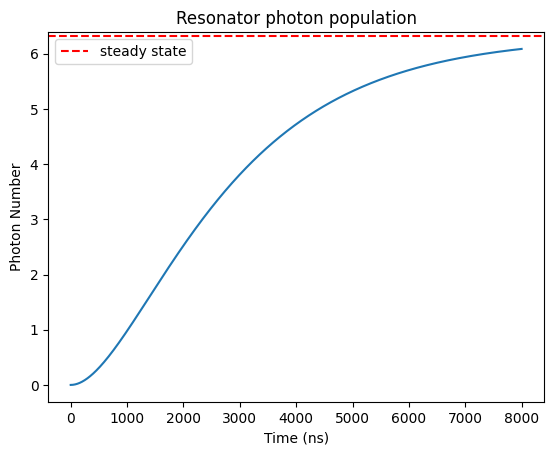

In [1114]:
plt.plot(times, result.expect[0])

# plt.plot(times, np.exp(-kappa * times), 'r--', label='decay')

steady_state_population = 4*(Omega/kappa)**2
plt.axhline(steady_state_population, color='r', linestyle='--', label='steady state')

plt.xlabel('Time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title('Resonator photon population')

plt.show()

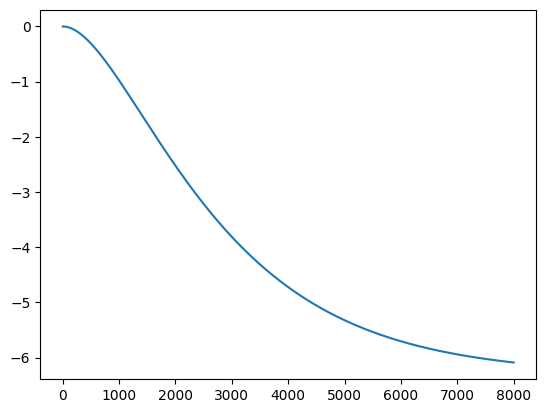

In [1115]:
plt.plot(times, result.expect[2].real)
plt.show()

In [1116]:
variance = result.expect[2] - result.expect[1]**2

In [1117]:
variance

array([ 0.00000000e+00+0.j, -5.52570166e-11+0.j, -1.07512893e-09+0.j, ...,
        1.97195860e-09+0.j,  2.37699194e-09+0.j,  2.24704610e-09+0.j])

In [1118]:
plt.plot(result.expect[1].real, result.expect[1].imag)
plt.xlabel('I')
plt.ylabel('Q')

plt.title('Resonator Drive IQ')

plt.show()

KeyboardInterrupt: 

C:\Users\mattm\AppData\Local\Temp\ipykernel_12652\257537792.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


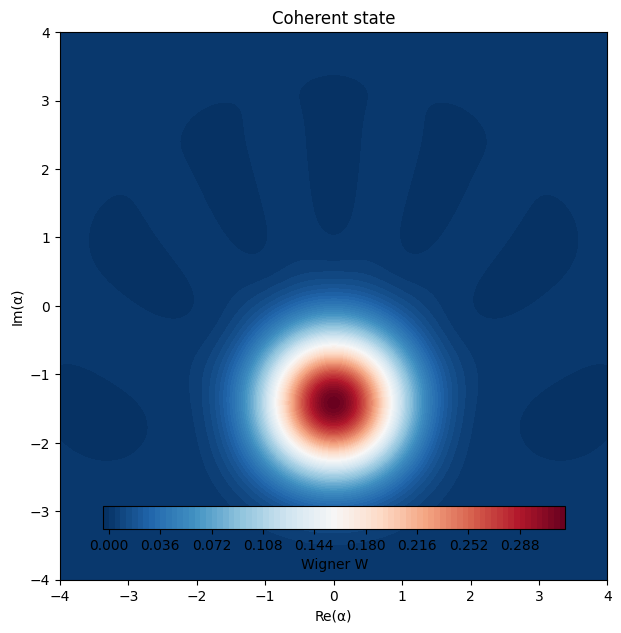

C:\Users\mattm\AppData\Local\Temp\ipykernel_12652\257537792.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


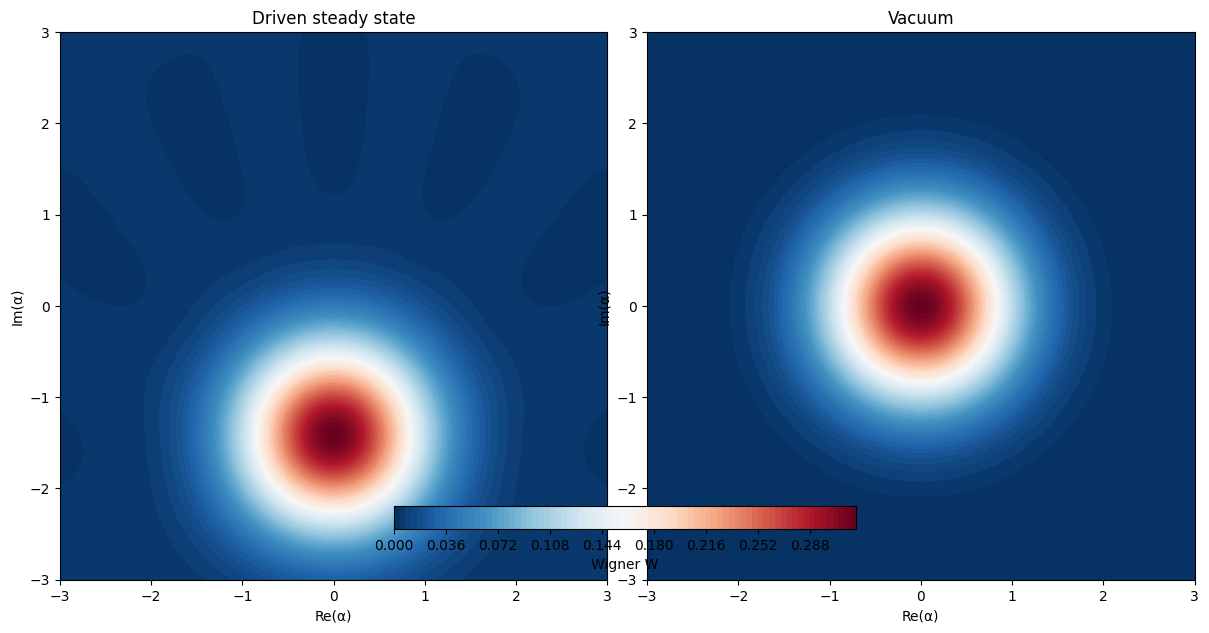

In [ ]:
# Single coherent state
alpha = -2j * Omega/kappa
psi_coh = qt.coherent(num_levels, alpha)
plot_wigners(psi_coh, xvec=np.linspace(-4,4,300), titles=["Coherent state"])

# Steady state + vacuum
rho_ss = qt.steadystate(H, c_ops)
vac = qt.basis(num_levels, 0)
plot_wigners([rho_ss, vac], titles=["Driven steady state", "Vacuum"], xvec=np.linspace(-3,3,200))


### 1.2 Plot Blobs

In [ ]:
num_levels = 8

a = qt.destroy(num_levels)

omega_r = 7.0 * 2 * np.pi  # frequency in GHz
kappa = 0.001  # decay rate

omega_d = 7.0 * 2 * np.pi
Omega = 0.0005 * 2 * np.pi  # Rabi frequency

H = (omega_d - omega_r) * a.dag() * a  + Omega*(a + a.dag())# Hamiltonian

times = np.linspace(0, 3000, 1001)  # time points

psi0 = qt.basis(num_levels, 0)  # initial state

c_ops = [np.sqrt(kappa) * a]  # collapse operators

result = qt.mesolve(H, psi0, times, c_ops)

i: Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
i: Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.91942921e-01+0.00000000e+00j  0.00000000e+00+8.92180880e-02j
  -5.67420913e-03+0.00000000e+00j  0.00000000e+00-2.94647472e-04j
   1.32465315e-05+0.00000000e+00j  0.00000000e+00+5.34443149e-07j
  -1.96162976e-08+0.00000000e+00j  0.00000000e+00-6.59705667e-10j]
 [ 0.00000000e+00-8.92180880e-02j  8.02454351e-03+0.00000000e+00j
   0.00000000e+00+5.10344392e-04j -2.64930629e-05+0.00000000e+00j
   0.00000000e+00-1.19505121e-06j  4.80499382e-08+0.00000000e+00j
   0.00000000e+00+1.74430184e-09j -5.54495317e-11+0.00000000e+00j]
 [-5.67420913e-03+0.00000000e+00j  0.00000000e+00-5.1

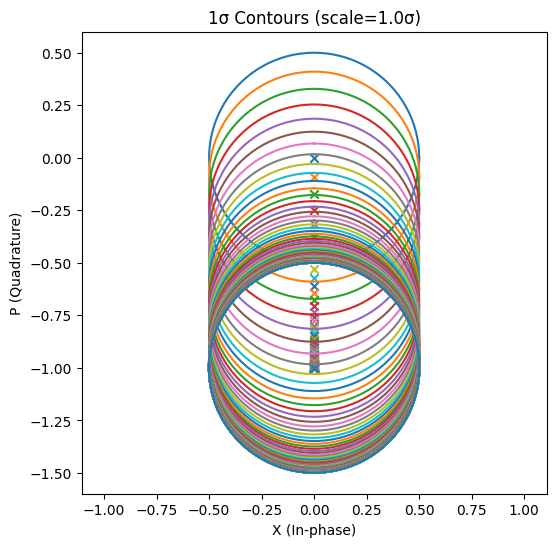

In [ ]:
selected_states = []
selected_times = []

for i in range(len(result.states)):
    if i % 10 == 0:
        print(f'i: {result.states[i]}')
        selected_states.append(result.states[i])
        selected_times.append(times[i])

print(len(selected_states))
plot_1sigma_contours(selected_states, a)


# 2. Qubit and Resonator

In [ ]:
def resonator_drive_minus_coeff(t, args):
    omega_d = args['omega_d']
    Omega = args['Omega']

    return Omega*(np.exp(1j * omega_d * t))

def resonator_drive_plus_coeff(t, args):
    omega_d = args['omega_d']
    Omega = args['Omega']

    return np.conjugate(Omega*(np.exp(1j * omega_d * t)))

### 2.1 Quantum Optics Parameters

#### 2.1.1 Dispersive Jaynes-Cummings

In [1228]:
### use paramters from quantum optics project

num_resonator_levels = 10
num_qubit_levels = 2

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))



omega_r = 6.44252 * 2 * np.pi
omega_a = 4.009 * 2 * np.pi

chi = -0.00069 * 2 * np.pi
print(f'chi: {chi/2/np.pi*1e3} MHz')


kappa = 0.00169 * 2 * np.pi
gamma_1 = 0.00019 * 2 * np.pi
gamma_phi = 2*gamma_1


epsilon_m = np.sqrt(kappa / 2) / 10
omega_m = omega_r - chi


# no qubit drive for this figure
Omega = 0
# lamb shift
omega_s = omega_a + chi

delta_rm = omega_r - omega_m
delta_as = -chi




sigma_z = 2*a_q.dag()*a_q - 1
a = a_r


H_disp = (
         (delta_rm + chi * sigma_z) * a_r.dag() * a_r
        + 1 / 2 * (delta_as + chi) * sigma_z
    )
H = H_disp + epsilon_m*(a_r + a_r.dag())



print(delta_rm)
print(chi)
print(delta_as)
print(epsilon_m)

print(kappa)
print(gamma_1)
print(gamma_phi)


# print(H)

args = {'omega_d': omega_d, 'Omega': Omega}

# print(H)


times = np.linspace(0, 5000, 501)  # time points

psi0_g = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # initial state
psi0_e = qt.basis([num_resonator_levels, num_qubit_levels], [0, 1])  # initial state

# print(psi0)


c_ops = [
    np.sqrt(kappa) * a_r,
    np.sqrt(gamma_1) * a_q,
    np.sqrt(gamma_phi) * a_q.dag() * a_q,
]

# c_ops = [np.sqrt(kappa) * a_r, np.sqrt(Gamma) * a_q]  # collapse operators
# e_ops = [a.dag() * a, a, a*a]

result_g = qt.mesolve(H, psi0_g, times, c_ops)
result_e = qt.mesolve(H, psi0_e, times, c_ops)

chi: -0.69 MHz
-0.004335397861950696
-0.004335397861953914
0.004335397861953914
0.0072864885813173075
0.010618583169133501
0.0011938052083641214
0.0023876104167282427


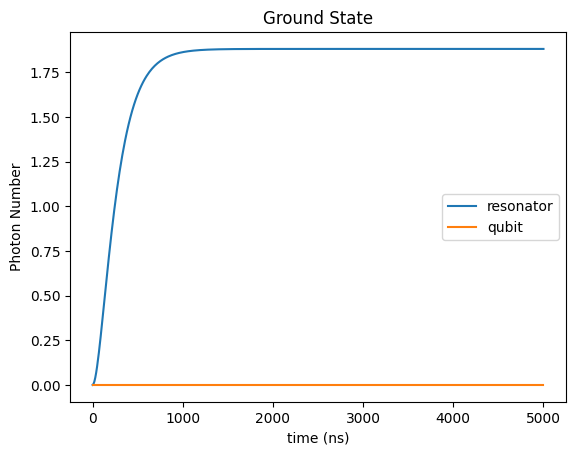

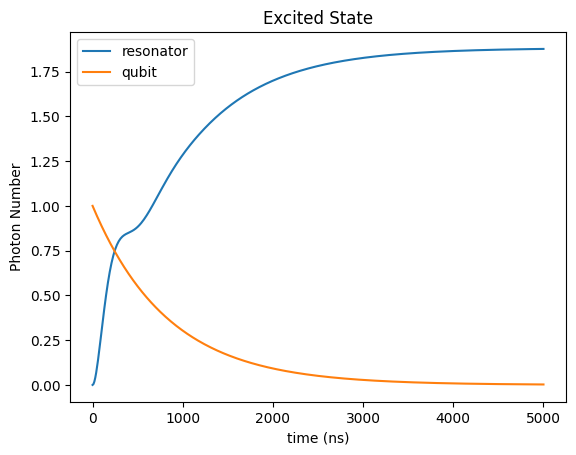

In [1229]:
photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_g.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.title('Ground State')
plt.legend()
plt.show()


photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_e.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.title('Excited State')
plt.legend()
plt.show()

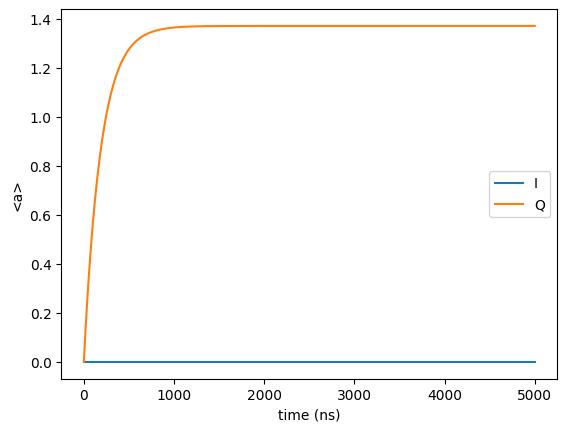

In [1230]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
plt.plot(times, np.abs(ground_state_a_expectation.real), label='I')
plt.plot(times, np.abs(ground_state_a_expectation.imag), label='Q')

plt.xlabel('time (ns)')
plt.ylabel('<a>')

plt.legend()
plt.show()

51
False


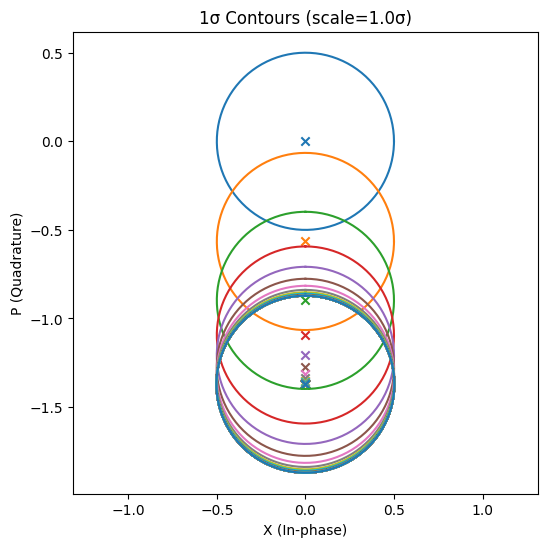

In [1231]:
selected_states = []
selected_times = []

for i in range(len(result_g.states)):
    if i % 10 == 0:
        selected_states.append(result_g.states[i])
        selected_times.append(times[i])

print(len(selected_states))
plot_1sigma_contours(selected_states, a_r)


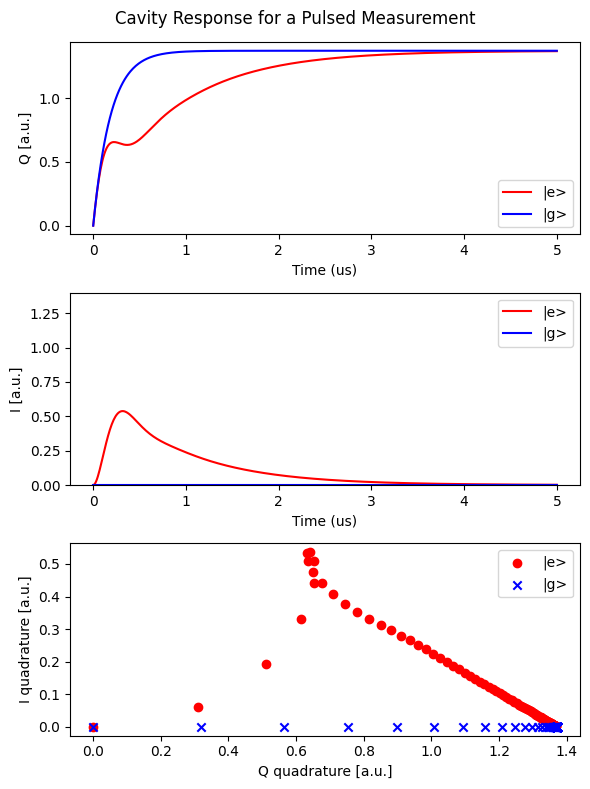

In [1232]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
excited_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_e.states])


I_g = np.abs(np.real(ground_state_a_expectation))
Q_g = np.abs(np.imag(ground_state_a_expectation))

I_e = np.abs(np.real(excited_state_a_expectation))
Q_e = np.abs(np.imag(excited_state_a_expectation))

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
times_g = np.array(result_g.times)/1000
ax[0].plot(times_g, Q_e, label="|e>", c='red')
ax[0].plot(times_g, Q_g, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(times_g, I_e, label='|e>', c='red')
ax[1].plot(times_g, I_g, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].scatter(Q_e[::5], I_e[::5], label='|e>', marker='o', c='red')
ax[2].scatter(Q_g[::5], I_g[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

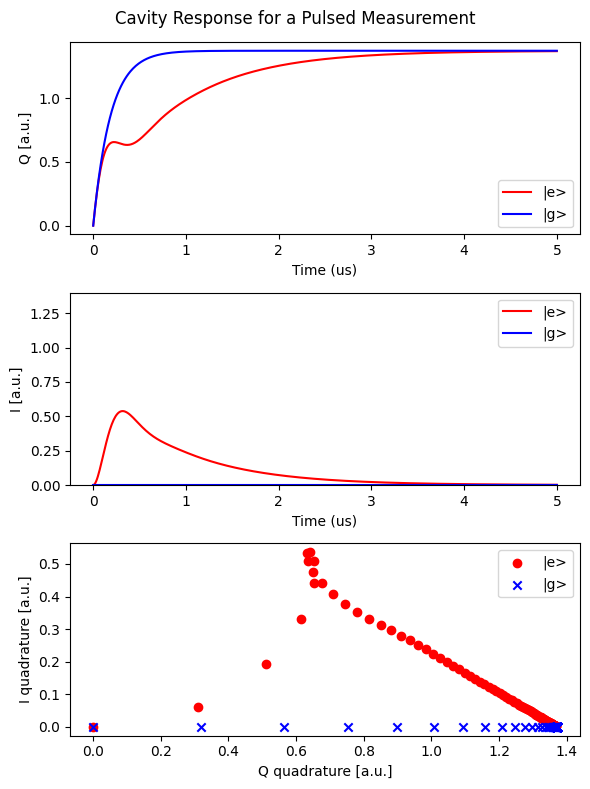

In [1233]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
excited_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_e.states])


I_g = np.abs(np.real(ground_state_a_expectation))
Q_g = np.abs(np.imag(ground_state_a_expectation))

I_e = np.abs(np.real(excited_state_a_expectation))
Q_e = np.abs(np.imag(excited_state_a_expectation))

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
times_g = np.array(result_g.times)/1000
ax[0].plot(times_g, Q_e, label="|e>", c='red')
ax[0].plot(times_g, Q_g, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(times_g, I_e, label='|e>', c='red')
ax[1].plot(times_g, I_g, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].scatter(Q_e[::5], I_e[::5], label='|e>', marker='o', c='red')
ax[2].scatter(Q_g[::5], I_g[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

ground state purity:


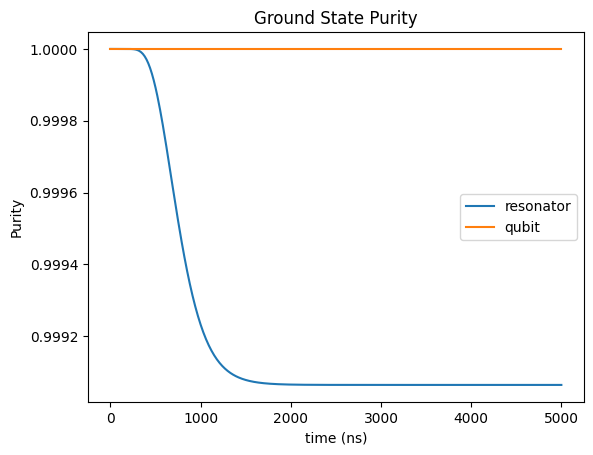

excited state purity:


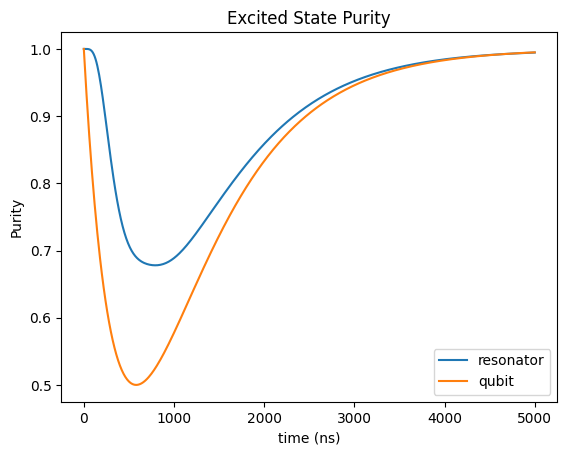

In [1234]:
### purity


### check purity of density matrix



print(f'ground state purity:')

ground_purities = np.zeros((2, len(result_g.states)))

for i in range(len(result_g.states)):
    state = result_g.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    ground_purities[0, i] = rho_r.purity()
    ground_purities[1, i] = rho_q.purity()

plt.plot(times, ground_purities[0], label='resonator')
plt.plot(times, ground_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Ground State Purity')
plt.legend()
plt.show()



print(f'excited state purity:')

excited_purities = np.zeros((2, len(result_e.states)))

for i in range(len(result_e.states)):
    state = result_e.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    excited_purities[0, i] = rho_r.purity()
    excited_purities[1, i] = rho_q.purity()

plt.plot(times, excited_purities[0], label='resonator')
plt.plot(times, excited_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Excited State Purity')
plt.legend()
plt.show()

###

### 2.1.2 Coupled Hamiltonian

In [ ]:
### use paramters from quantum optics project

num_resonator_levels = 10
num_qubit_levels = 2

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))



omega_r = 6.44252 * 2 * np.pi
omega_q = 4.009 * 2 * np.pi


U = -0.2 * 2 * np.pi
g = 0.1 * 2 * np.pi
Delta = omega_q - omega_r

chi = -0.00069 * 2 * np.pi
chi = g**2 / Delta


kappa = 0.00169 * 2 * np.pi
gamma_1 = 0.00019 * 2 * np.pi
gamma_phi = 2*gamma_1


epsilon_m = np.sqrt(kappa / 2) / 10



times = np.linspace(0, 1000, 101)  # time points

psi0 = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # initial state

c_ops = [
    np.sqrt(kappa) * a_r,
    np.sqrt(gamma_1) * a_q,
    np.sqrt(gamma_phi) * a_q.dag() * a_q,
]


omega_ds = np.linspace(omega_r - 1.5*chi, omega_r + 1.5*chi, 41)
omega_ds = np.linspace(omega_r - 1.5*chi, omega_r - 0.5*chi, 41)
resonator_populations = np.zeros((len(omega_ds), len(times)))
for i in range(len(omega_ds)):

    omega_d = omega_ds[i]

    print(f'{i}: {omega_d/2/np.pi*1e3} MHz')

    H_rwa = (omega_q - omega_d) * a_q.dag()*a_q + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_q.dag()*a_q * (a_q.dag()*a_q - 1)
    H_rwa += g*(a_q.dag()*a_r + a_r.dag()*a_q)
    H_rwa += epsilon_m*(a_r + a_r.dag())

    if i == 10:
        print(H_rwa/2/np.pi)

# print(H_disp)
# print(H_rwa)

# eigenenergies, eigenstates = H_rwa.eigenstates()

# print((eigenenergies - eigenenergies[0])/2/np.pi)

    ground_state_result = qt.mesolve(H_rwa, psi0, times, c_ops)

    resonator_populations[i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in ground_state_result.states])

0: 6448.683910713698 MHz
1: 6448.5811788684705 MHz
2: 6448.478447023243 MHz
3: 6448.375715178012 MHz
4: 6448.272983332784 MHz
5: 6448.170251487556 MHz
6: 6448.067519642328 MHz
7: 6447.9647877971 MHz
8: 6447.862055951871 MHz
9: 6447.759324106643 MHz
10: 6447.656592261415 MHz
Quantum object: dims=[[10, 2], [10, 2]], shape=(20, 20), type='oper', dtype=Dia, isherm=True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  1.15968068e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.43865659e+00  1.00000000e-01  1.15968068e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.0000

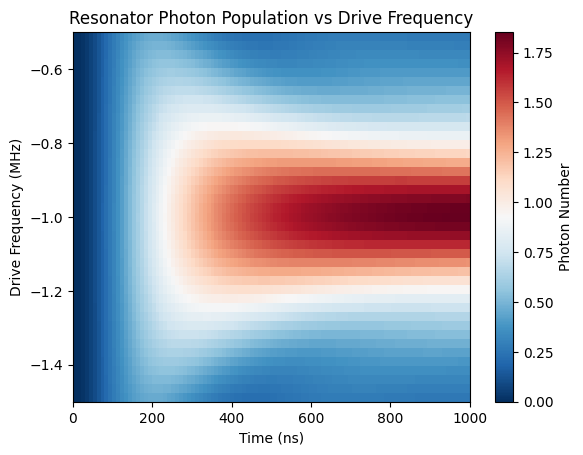

In [ ]:
y_axis = (omega_ds - omega_r)/chi
# y_axis = omega_ds

plt.imshow(resonator_populations, origin='lower', aspect='auto', cmap='RdBu_r', extent=[times[0], times[-1], y_axis[0], y_axis[-1]])
plt.colorbar(label='Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Frequency (MHz)')
plt.title('Resonator Photon Population vs Drive Frequency')
plt.show()

In [ ]:
### use paramters from quantum optics project

num_resonator_levels = 10
num_qubit_levels = 3

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))



omega_r = 6.44252 * 2 * np.pi
omega_q = 4.009 * 2 * np.pi


U = -0.2 * 2 * np.pi
g = 0.1 * 2 * np.pi
Delta = omega_q - omega_r

chi = -0.00069 * 2 * np.pi
chi = g**2 / Delta


kappa = 0.00169 * 2 * np.pi
gamma_1 = 0.00019 * 2 * np.pi
gamma_phi = 2*gamma_1


epsilon_m = np.sqrt(kappa / 2) / 10


omega_d = omega_r - chi


times = np.linspace(0, 1000, 101)  # time points

psi0_g = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # initial state
psi0_e = qt.basis([num_resonator_levels, num_qubit_levels], [0, 1])  # initial state

c_ops = [
    np.sqrt(kappa) * a_r,
    np.sqrt(gamma_1) * a_q,
    np.sqrt(gamma_phi) * a_q.dag() * a_q,
]



H_rwa = (omega_q - omega_d) * a_q.dag()*a_q + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_q.dag()*a_q * (a_q.dag()*a_q - 1)
H_rwa += g*(a_q.dag()*a_r + a_r.dag()*a_q)
H_rwa += epsilon_m*(a_r + a_r.dag())

# print(H_disp)
# print(H_rwa)

# eigenenergies, eigenstates = H_rwa.eigenstates()

# print((eigenenergies - eigenenergies[0])/2/np.pi)

result_g = qt.mesolve(H_rwa, psi0_g, times, c_ops)
result_e = qt.mesolve(H_rwa, psi0_e, times, c_ops)


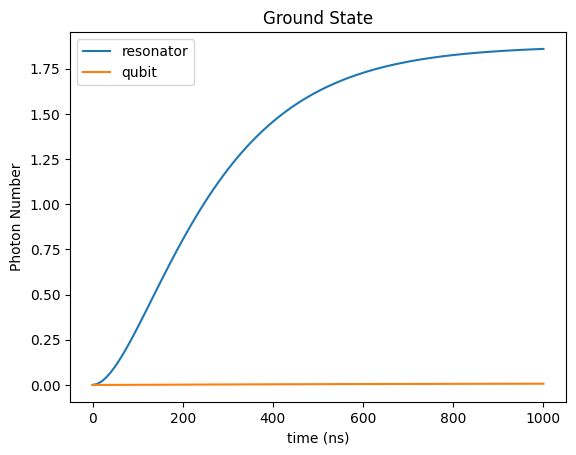

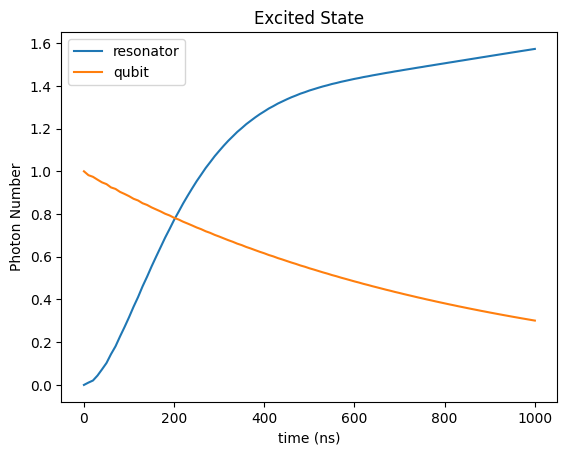

In [ ]:
photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_g.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.title('Ground State')
plt.legend()
plt.show()


photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_e.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.title('Excited State')
plt.legend()
plt.show()

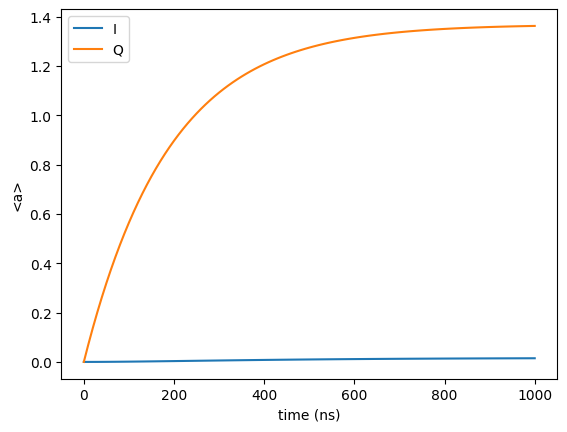

In [ ]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
plt.plot(times, np.abs(ground_state_a_expectation.real), label='I')
plt.plot(times, np.abs(ground_state_a_expectation.imag), label='Q')

plt.xlabel('time (ns)')
plt.ylabel('<a>')

plt.legend()
plt.show()

11
False


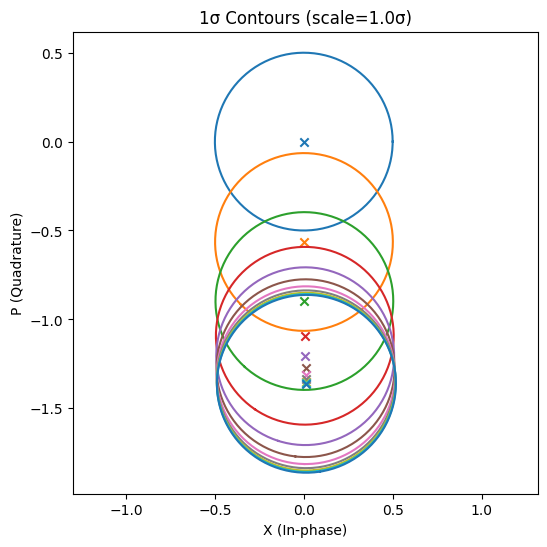

In [ ]:
selected_states = []
selected_times = []

for i in range(len(result_g.states)):
    if i % 10 == 0:
        selected_states.append(result_g.states[i])
        selected_times.append(times[i])

print(len(selected_states))
plot_1sigma_contours(selected_states, a_r)


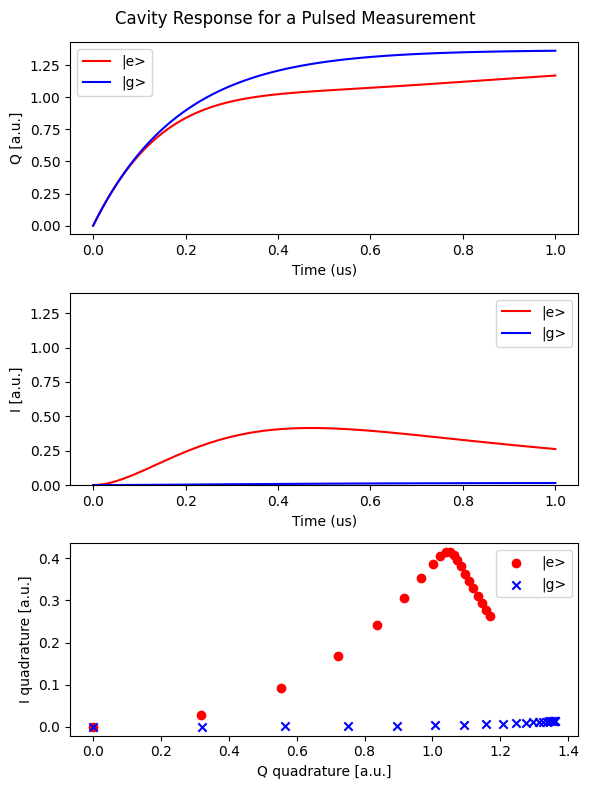

In [ ]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
excited_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_e.states])


I_g = np.abs(np.real(ground_state_a_expectation))
Q_g = np.abs(np.imag(ground_state_a_expectation))

I_e = np.abs(np.real(excited_state_a_expectation))
Q_e = np.abs(np.imag(excited_state_a_expectation))

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
times_g = np.array(result_g.times)/1000
ax[0].plot(times_g, Q_e, label="|e>", c='red')
ax[0].plot(times_g, Q_g, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(times_g, I_e, label='|e>', c='red')
ax[1].plot(times_g, I_g, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].scatter(Q_e[::5], I_e[::5], label='|e>', marker='o', c='red')
ax[2].scatter(Q_g[::5], I_g[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

### 2.2 8QTri Parameters
#### 2.2.1 Dispersive Jaynes-Cummings Hamiltonian

In [1235]:
num_resonator_levels = 20
num_qubit_levels = 3

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))

omega_q = 4.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

g = 0.1 * 2 * np.pi

U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi


# omega_r = 6.44252 * 2 * np.pi
# omega_a = 4.009 * 2 * np.pi

# chi = -0.00069 * 2 * np.pi
# print(f'chi: {chi/2/np.pi*1e3} MHz')


# kappa = 0.00169 * 2 * np.pi
# Gamma_1 = 0.00019 * 2 * np.pi
# Gamma_phi = 2*Gamma_1
# omega_d = omega_r - chi

# epsilon_m = np.sqrt(kappa / 2) / 10
# Omega = epsilon_m


# onsite energy and interaction
# H = omega_q * a_q.dag()*a_q + omega_r * a_r.dag()*a_r + U/2*a_q.dag()*a_q*(a_q.dag()*a_q - 1)

# # not sure if this is right, want to rotate into frame 
# H = (omega_q - omega_d) * a_q.dag()*a_q + (omega_r - omega_d) * a_r.dag()*a_r

# # qubit resonator interaction
# H += g * (a_q.dag()*a_r + a_r.dag()*a_q)

# # drive
# H += Omega*(a_r + a_r.dag())

# H = (omega_r - omega_q) (omega_d - omega_r) * a.dag() * a  + Omega*(a + a.dag())# Hamiltonian



##################

# omega_r = 6.44252 * 2 * np.pi
# omega_a = 4.009 * 2 * np.pi

# chi = -0.00069 * 2 * np.pi
# print(f'chi: {chi/2/np.pi*1e3} MHz')


# kappa = 0.00169 * 2 * np.pi
# Gamma_1 = 0.00019 * 2 * np.pi
# Gamma_phi = 2*Gamma_1


# Omega = np.sqrt(kappa / 2) / 10

# omega_d = omega_r - chi


##################


H = (omega_r - omega_d + chi*(2*a_q.dag()*a_q - 1))*a_r.dag()*a_r + 0*(omega_q + chi)*(a_q.dag()*a_q - 1/2) + U/2*a_q.dag()*a_q*(a_q.dag()*a_q - 1)
H += Omega*(a_r + a_r.dag())
# print(H)




times = np.linspace(0, 4000, 501)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # ground state
psi_e = qt.basis([num_resonator_levels, num_qubit_levels], [0, 1])  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_q,
    np.sqrt(Gamma_phi) * a_q.dag()*a_q
]  # collapse operators

result_g = qt.mesolve(H, psi_g, times, c_ops)
result_e = qt.mesolve(H, psi_e, times, c_ops)

print(len(result.states))

expected photon number: 4.0
chi: 1.0 MHz
501


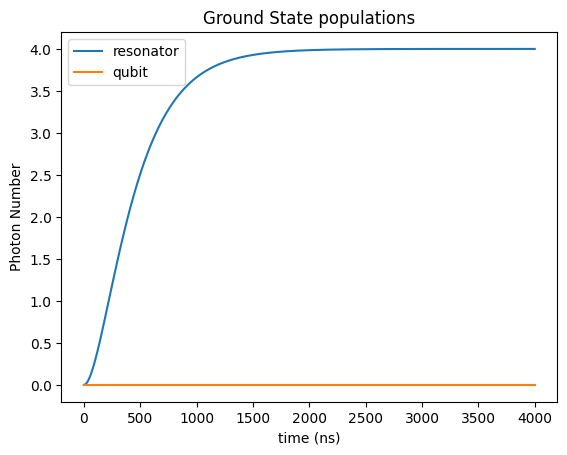

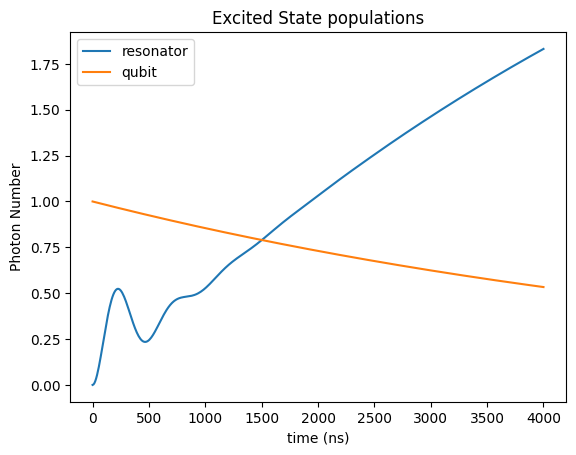

In [1236]:
photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_g.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Ground State populations")
plt.show()

photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_e.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Excited State populations")
plt.show()

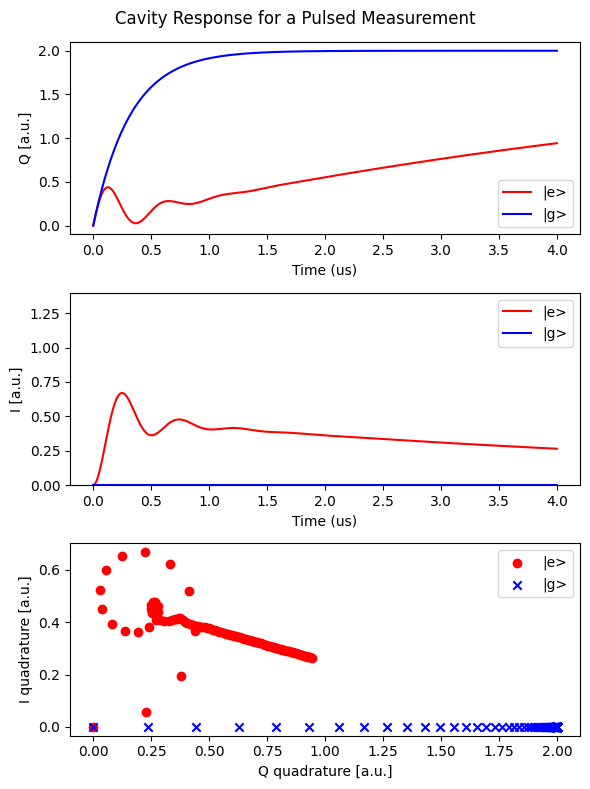

In [1237]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
excited_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_e.states])


I_g = np.abs(np.real(ground_state_a_expectation))
Q_g = np.abs(np.imag(ground_state_a_expectation))

I_e = np.abs(np.real(excited_state_a_expectation))
Q_e = np.abs(np.imag(excited_state_a_expectation))

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
times_g = np.array(result_g.times)/1000
ax[0].plot(times_g, Q_e, label="|e>", c='red')
ax[0].plot(times_g, Q_g, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(times_g, I_e, label='|e>', c='red')
ax[1].plot(times_g, I_g, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].scatter(Q_e[::5], I_e[::5], label='|e>', marker='o', c='red')
ax[2].scatter(Q_g[::5], I_g[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

51
False


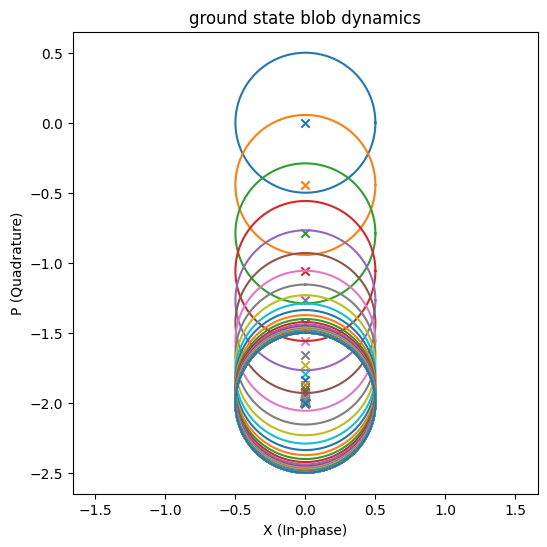

51
False


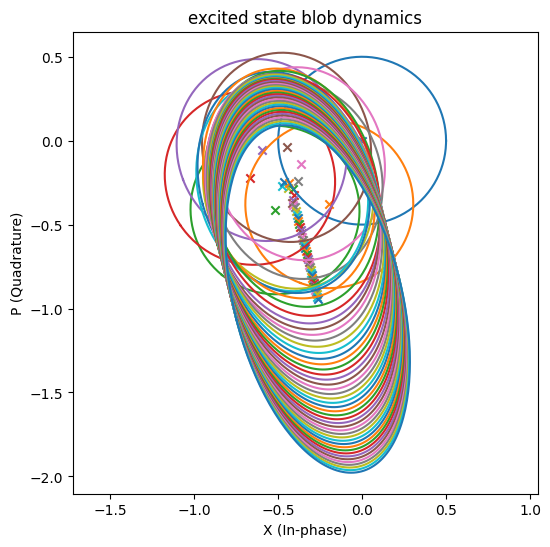

In [1238]:
selected_states = []
selected_times = []

for i in range(len(result_g.states)):
    if i % 10 == 0:
        selected_states.append(result_g.states[i])
        selected_times.append(times[i])

print(len(selected_states))
plot_1sigma_contours(selected_states, a_r, title='ground state blob dynamics')


selected_states = []
selected_times = []

for i in range(len(result_e.states)):
    if i % 10 == 0:
        selected_states.append(result_e.states[i])
        selected_times.append(times[i])

print(len(selected_states))
plot_1sigma_contours(selected_states, a_r, title='excited state blob dynamics')


ground state purity:


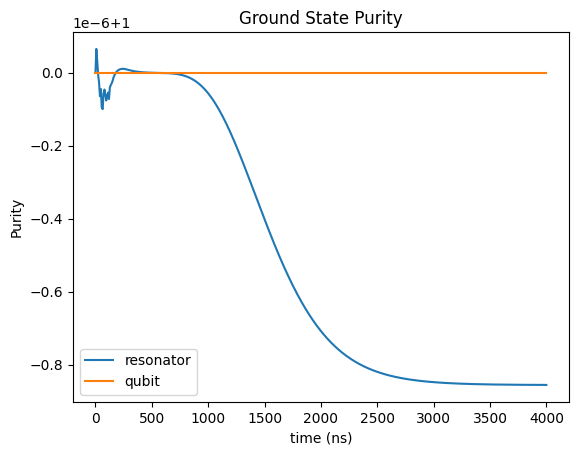

excited state purity:


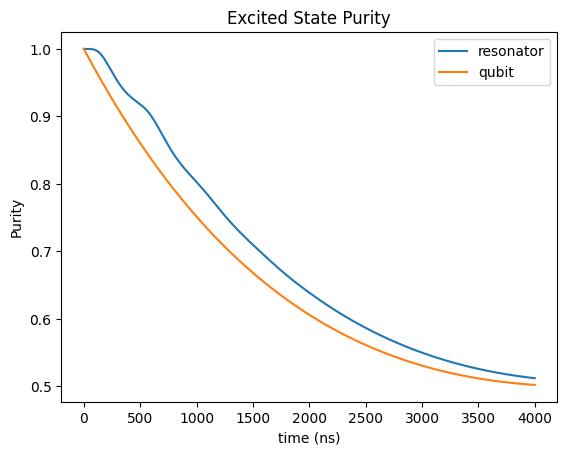

In [1239]:
### purity


### check purity of density matrix



print(f'ground state purity:')

ground_purities = np.zeros((2, len(result_g.states)))

for i in range(len(result_g.states)):
    state = result_g.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    ground_purities[0, i] = rho_r.purity()
    ground_purities[1, i] = rho_q.purity()

plt.plot(times, ground_purities[0], label='resonator')
plt.plot(times, ground_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Ground State Purity')
plt.legend()
plt.show()



print(f'excited state purity:')

excited_purities = np.zeros((2, len(result_e.states)))

for i in range(len(result_e.states)):
    state = result_e.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    excited_purities[0, i] = rho_r.purity()
    excited_purities[1, i] = rho_q.purity()

plt.plot(times, excited_purities[0], label='resonator')
plt.plot(times, excited_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Excited State Purity')
plt.legend()
plt.show()

#### 2.2.2 Coupled Hamiltonian

In [1210]:
num_resonator_levels = 10
num_qubit_levels = 2

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))

omega_q = 4.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

g = 0.1 * 2 * np.pi

U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.0005 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi





times = np.linspace(0, 4000, 501)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # ground state
psi_e = qt.basis([num_resonator_levels, num_qubit_levels], [0, 1])  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_q,
    np.sqrt(Gamma_phi) * a_q.dag()*a_q
]  # collapse operators






omega_ds = np.linspace(omega_r + 2*chi, omega_r + 4*chi, 21)
resonator_populations = np.zeros((2, len(omega_ds), len(times)))

for i in range(len(omega_ds)):

    omega_d = omega_ds[i]
    print(f'{i}: {omega_d/2/np.pi*1e3} MHz')

    H = (omega_q - omega_d) * a_q.dag()*a_q + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_q.dag()*a_q * (a_q.dag()*a_q - 1)
    H += g*(a_q.dag()*a_r + a_r.dag()*a_q)
    H += Omega*(a_r + a_r.dag())


    result_g = qt.mesolve(H, psi_g, times, c_ops)
    result_e = qt.mesolve(H, psi_e, times, c_ops)

    resonator_populations[0,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
    resonator_populations[1,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e.states])



expected photon number: 1.0
chi: 1.0 MHz
0: 7002.0 MHz
1: 7002.099999999999 MHz
2: 7002.2 MHz
3: 7002.3 MHz
4: 7002.4 MHz
5: 7002.5 MHz


KeyboardInterrupt: 

In [ ]:
(omega_ds[15] - omega_r)/2/np.pi

0.0034999999999994996

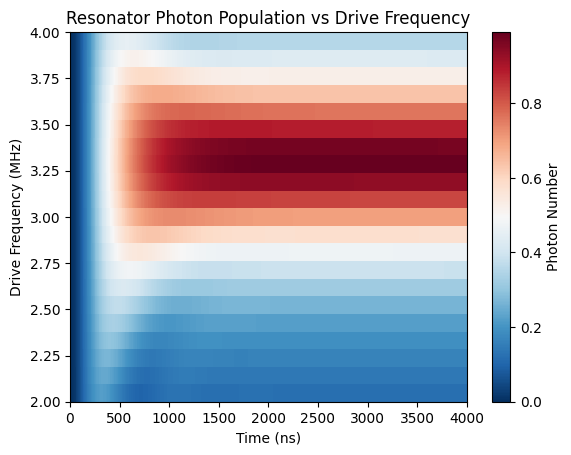

In [ ]:
    
y_axis = (omega_ds - omega_r)/chi
# y_axis = omega_ds

plt.imshow(resonator_populations[0,:,:], origin='lower', interpolation='none', aspect='auto', cmap='RdBu_r', extent=[times[0], times[-1], y_axis[0], y_axis[-1]])
plt.colorbar(label='Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Frequency (MHz)')
plt.title('Resonator Photon Population vs Drive Frequency')
plt.show()

In [ ]:
num_resonator_levels = 10
num_qubit_levels = 3

a_q = qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor(qt.destroy(num_resonator_levels), qt.qeye(num_qubit_levels))

omega_q = 4.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

g = 0.1 * 2 * np.pi

U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi

# gotten from the chevron
omega_d = omega_r + 0.0033 * 2 * np.pi




times = np.linspace(0, 4000, 501)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels], [0, 0])  # ground state
psi_e = qt.basis([num_resonator_levels, num_qubit_levels], [0, 1])  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_q,
    np.sqrt(Gamma_phi) * a_q.dag()*a_q
]  # collapse operators



H = (omega_q - omega_d) * a_q.dag()*a_q + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_q.dag()*a_q * (a_q.dag()*a_q - 1)
H += g*(a_q.dag()*a_r + a_r.dag()*a_q)
H += Omega*(a_r + a_r.dag())


result_g = qt.mesolve(H, psi_g, times, c_ops)
result_e = qt.mesolve(H, psi_e, times, c_ops)



expected photon number: 4.0
chi: 1.0 MHz


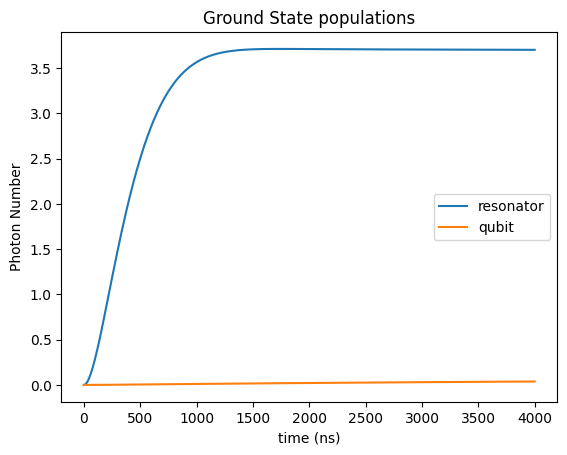

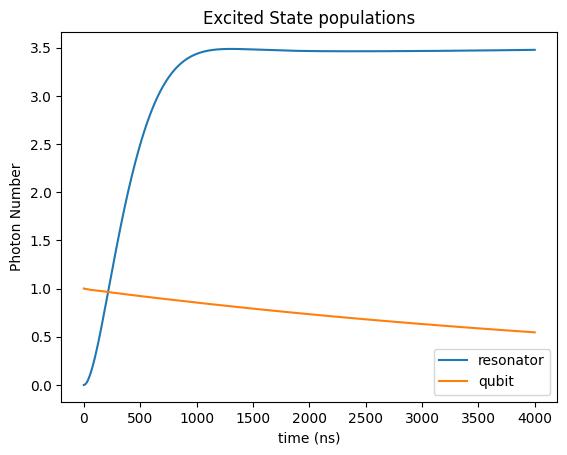

In [ ]:
photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_g.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Ground State populations")
plt.show()

photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e.states])
qubit_population = np.array([qt.expect(a_q.dag()*a_q, state) for state in result_e.states])
plt.plot(times, photon_number_expectation, label='resonator')
plt.plot(times, qubit_population, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Excited State populations")
plt.show()

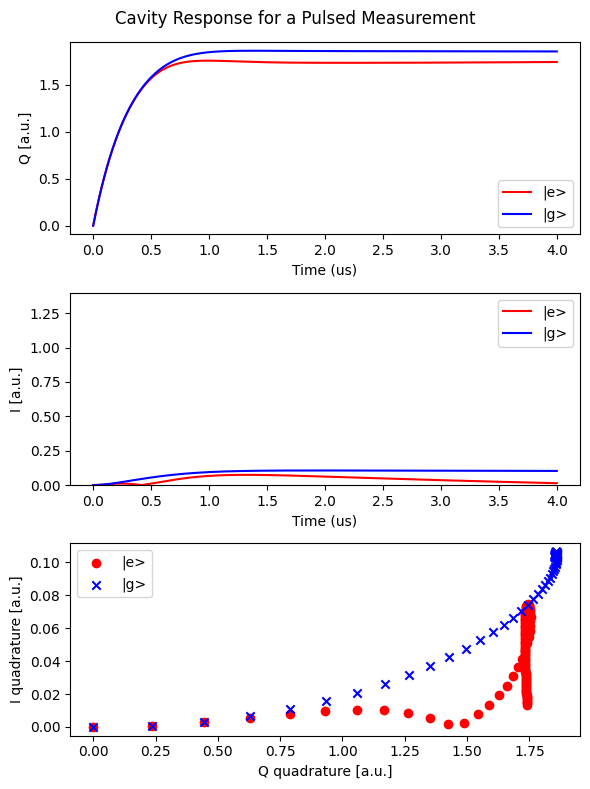

In [ ]:
ground_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_g.states])
excited_state_a_expectation = np.array([qt.expect(a_r, state) for state in result_e.states])

# ground_state_a_expectation = rotate_IQ(ground_state_a_expectation)
# excited_state_a_expectation = rotate_IQ(excited_state_a_expectation)



I_g = np.abs(np.real(ground_state_a_expectation))
Q_g = np.abs(np.imag(ground_state_a_expectation))

I_e = np.abs(np.real(excited_state_a_expectation))
Q_e = np.abs(np.imag(excited_state_a_expectation))

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
times_g = np.array(result_g.times)/1000
ax[0].plot(times_g, Q_e, label="|e>", c='red')
ax[0].plot(times_g, Q_g, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(times_g, I_e, label='|e>', c='red')
ax[1].plot(times_g, I_g, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].scatter(Q_e[::5], I_e[::5], label='|e>', marker='o', c='red')
ax[2].scatter(Q_g[::5], I_g[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

In [ ]:
### purity


### check purity of density matrix



print(f'ground state purity:')

ground_purities = np.zeros((2, len(result_g.states)))

for i in range(len(result_g.states)):
    state = result_g.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    ground_purities[0, i] = rho_r.purity()
    ground_purities[1, i] = rho_q.purity()

plt.plot(times, ground_purities[0], label='resonator')
plt.plot(times, ground_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Ground State Purity')
plt.legend()
plt.show()



print(f'excited state purity:')

excited_purities = np.zeros((2, len(result_e.states)))

for i in range(len(result_e.states)):
    state = result_e.states[i]
    rho_r = state.ptrace(0)
    rho_q = state.ptrace(1)
    excited_purities[0, i] = rho_r.purity()
    excited_purities[1, i] = rho_q.purity()

plt.plot(times, excited_purities[0], label='resonator')
plt.plot(times, excited_purities[1], label='qubit')
plt.xlabel('time (ns)')
plt.ylabel('Purity')
plt.title('Excited State Purity')
plt.legend()
plt.show()

### 2.4 Cavity Bloch equations

In [ ]:
def cavity_bloch_rhs(t, y, *args):
    delta_rm, chi, epsilon_m, kappa, Omega, gamma_1, delta_as, gamma_phi = args

    a = y[0]
    sigmaz = y[1]
    sigmax = y[2]
    sigmay = y[3]
    a_sigmaz = y[4]
    a_sigmax = y[5]
    a_sigmay = y[6]
    adagger_a = y[7]

    ydot = np.array([0j] * len(y))

    ydot[0] = -1j * delta_rm * a - 1j * chi * a_sigmaz - 1j * epsilon_m - kappa / 2 * a
    ydot[1] = Omega * sigmay - gamma_1 * (1 + sigmaz)
    ydot[2] = - (gamma_1 / 2 + gamma_phi) * sigmax
    ydot[3] = - (gamma_1 / 2 + gamma_phi) * sigmay - Omega * sigmaz
    ydot[
        4] = -1j * delta_rm * a_sigmaz - 1j * chi * a + Omega * a_sigmay - 1j * epsilon_m * sigmaz - gamma_1 * a - (
            gamma_1 + kappa / 2) * a_sigmaz
    ydot[5] = -1j * delta_rm * a_sigmax - chi * a_sigmay - 1j * epsilon_m * sigmax - (
            gamma_1 / 2 + gamma_phi + kappa / 2) * a_sigmax
    ydot[6] = -1j * delta_rm * a_sigmay + chi * a_sigmax - 1j * epsilon_m * sigmay - (
            gamma_1 / 2 + gamma_phi + kappa / 2) * a_sigmay - Omega * a_sigmaz
    ydot[7] = -2 * epsilon_m * np.imag(a) - kappa * adagger_a

    return ydot

In [ ]:
def rotate_IQ(a):
    # want last element of Q to be fully imaginary
    last = a[-1]
    return a * 1j * np.conjugate(last) / np.abs(last)

In [ ]:

# --- Parameters (GHz or ns units) ---
omega_q = 4.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

kappa = 0.001 * 2 * np.pi  # resonator decay rate (1/ns)

T1 = 40000 # (ns)
gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
gamma_2 = 2*np.pi/T2
gamma_phi = gamma_2 - Gamma_1/2

Delta = omega_r - omega_q

E_c = 200 # MHz
g = 0.100 * 2 * np.pi
chi = g**2/Delta * E_c/(E_c + Delta)

chi = 0.001 * 2 * np.pi


epsilon_m = 0.1 * 2 * np.pi  # resonator drive strength (GHz)
epsilon_m = 0.01 * 2 * np.pi  # resonator drive strength (GHz)

print(f'steady state photon number: {4*(epsilon_m/kappa)**2}')

# epsilon_m = np.sqrt(kappa / 2)
omega_d = omega_r - chi
omega_s = omega_q + chi

delta_as = omega_q - omega_s
delta_rd = omega_r - omega_d
Omega = 0

###########
# quantum optics parameters

# omega_r = 6.44252 * 2 * np.pi
# kappa = 0.00169 * 2 * np.pi

# omega_a = 4.009 * 2 * np.pi

# g = 0.134 * 2 * np.pi

# chi = -0.00069 * 2 * np.pi

# using the other value instead of this causes some weird things
# there are more loops in the trajectory, I think it's normal
# gamma_1 = 0.00019 * 2 * np.pi

# gamma_phi = 2 * gamma_1


# epsilon_m = np.sqrt(kappa / 2)

# omega_d = omega_r - chi
# omega_s = omega_q + chi
# delta_as = omega_q - omega_s
# delta_rd = omega_r - omega_d
# Omega = 0

print(f'kappa: {kappa/2/np.pi*1e3} MHz')
print(f'chi: {chi/2/np.pi*1e3} MHz')
print(f'epsilon_m: {epsilon_m/2/np.pi*1e3} MHz')

print(f'omega_s: {omega_s/2/np.pi*1e3} MHz')
print(f'omega_d: {omega_d/2/np.pi*1e3} MHz')
print(f'delta_as: {delta_as/2/np.pi*1e3} MHz')
print(f'delta_rd: {delta_rd/2/np.pi*1e3} MHz')

#########

a0 = 0j
sigmaz0 = 1
sigmax0 = 0
sigmay0 = 0
a_sigmaz0 = a0 * sigmaz0
a_sigmax0 = a0 * sigmax0
a_sigmay0 = a0 * sigmay0
adagger_a0 = 0

y0_g = np.array([a0, -sigmaz0, sigmay0, sigmax0, -a_sigmaz0, a_sigmay0, a_sigmax0, adagger_a0])
y0_e = np.array([a0, sigmaz0, sigmay0, sigmax0, a_sigmaz0, a_sigmay0, a_sigmax0, adagger_a0])

args = delta_rd, chi, epsilon_m, kappa, Omega, gamma_1, delta_as, gamma_phi


# --- Time span ---
t_max = 50000  # ns
t_eval = np.linspace(0, t_max, 10001)

# ground state
# --- Integrate ---
sol = solve_ivp(cavity_bloch_rhs, (0, t_max), y0_g, t_eval=t_eval, method='BDF', args=args)

# --- Extract results ---
a_g = sol.y[0]
a_g_rotated = rotate_IQ(a_g)


sigma_z_g = sol.y[1]
qubit_population_g = (sigma_z_g + 1) / 2
photon_number_g = sol.y[7]



# --- Plot trajectory of ⟨a⟩ (IQ)
# plt.figure(figsize=(6,6))
# plt.plot(np.real(a_g_rotated), np.imag(a_g_rotated), label='⟨a(t)⟩ trajectory')
# plt.scatter(np.real(a_g_rotated[0]), np.imag(a_g_rotated[0]), color='green', label='start')
# plt.scatter(np.real(a_g_rotated[-1]), np.imag(a_g_rotated[-1]), color='red', label='end')
# plt.xlabel("Re⟨a⟩ (I)")
# plt.ylabel("Im⟨a⟩ (Q)")
# plt.title("Cavity Field ⟨a⟩ in IQ Plane (ground state)")
# plt.axis('equal')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



# excited state
# --- Integrate ---
sol = solve_ivp(cavity_bloch_rhs, (0, t_max), y0_e, t_eval=t_eval, method='BDF', args=args)

# --- Extract results ---
a_e = sol.y[0]
a_e_rotated = rotate_IQ(a_e)

sigma_z_e = sol.y[1]
qubit_population_e = (sigma_z_e + 1) / 2
photon_number_e = sol.y[7]

# --- Plot trajectory of ⟨a⟩ (IQ)
# plt.figure(figsize=(6,6))
# plt.plot(np.real(a_e_rotated), np.imag(a_e_rotated), label='⟨a(t)⟩ trajectory')
# plt.scatter(np.real(a_e_rotated[0]), np.imag(a_e_rotated[0]), color='green', label='start')
# plt.scatter(np.real(a_e_rotated[-1]), np.imag(a_e_rotated[-1]), color='red', label='end')
# plt.xlabel("Re⟨a⟩ (I)")
# plt.ylabel("Im⟨a⟩ (Q)")
# plt.title("Cavity Field ⟨a⟩ in IQ Plane (excited state)")
# plt.axis('equal')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()






steady state photon number: 400.0
kappa: 1.0 MHz
chi: 1.0 MHz
epsilon_m: 10.0 MHz
omega_s: 4001.0000000000005 MHz
omega_d: 6999.0 MHz
delta_as: -0.9999999999999378 MHz
delta_rd: 1.0000000000005034 MHz


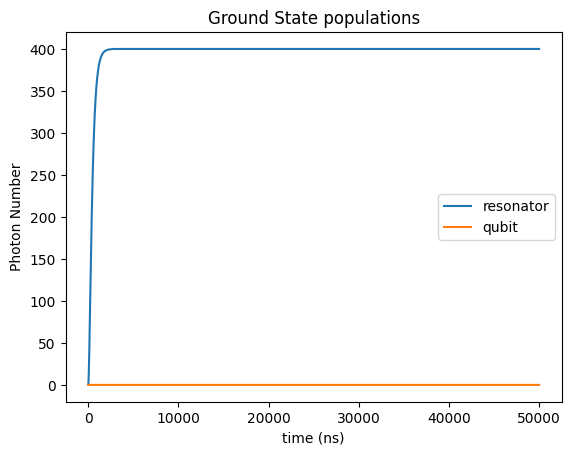

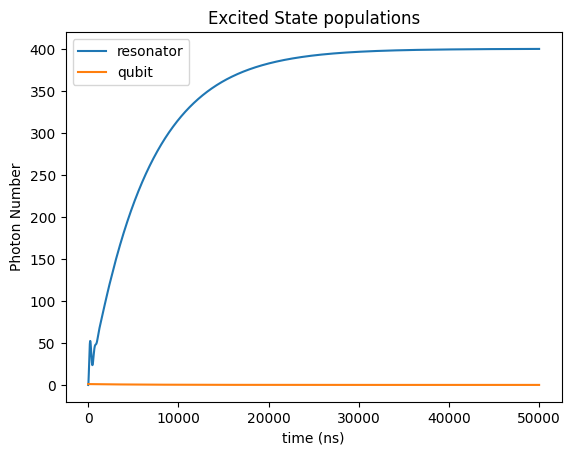

In [ ]:
plt.plot(sol.t, photon_number_g, label='resonator')
plt.plot(sol.t, qubit_population_g, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Ground State populations")
plt.show()

plt.plot(sol.t, photon_number_e, label='resonator')
plt.plot(sol.t, qubit_population_e, label='qubit')

# plt.plot(times, np.exp(-1/T1 * times), 'r--', label='decay')

plt.xlabel('time (ns)')
plt.ylabel('Photon Number')
plt.legend()

plt.title("Excited State populations")
plt.show()

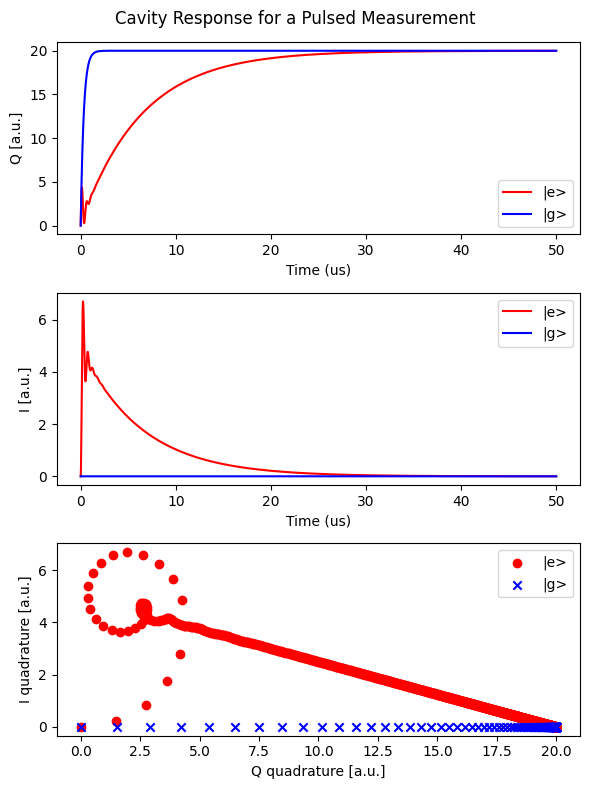

In [ ]:
# plot both ground and excited states together

fig, ax = plt.subplots(3, 1, figsize=(6, 8))
ax[0].plot(sol.t / 1000, a_e_rotated.imag, label="|e>", c='red')
ax[0].plot(sol.t / 1000, a_g_rotated.imag, label="|g>", c='blue')
ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].plot(sol.t / 1000, a_e_rotated.real, label='|e>', c='red')
ax[1].plot(sol.t / 1000, a_g_rotated.real, label='|g>', c='blue')
ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
# ax[1].set_ylim(0, 14)

ax[2].scatter(a_e_rotated.imag[::5], a_e_rotated.real[::5], label='|e>', marker='o', c='red')
ax[2].scatter(a_g_rotated.imag[::5], a_g_rotated.real[::5], label='|g>', marker='x', c='blue')
ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

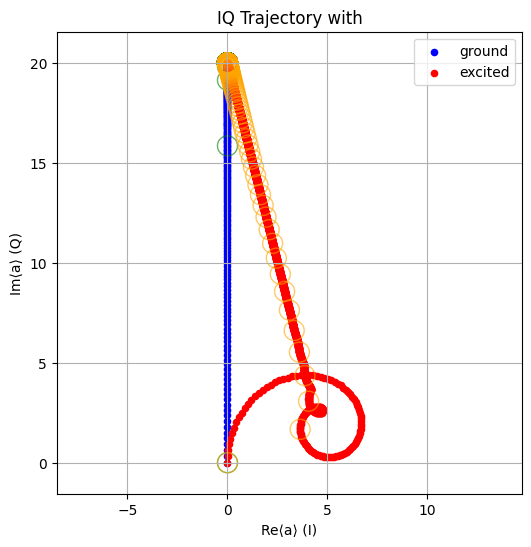

In [ ]:
# assume gaussian std is 0.5
radius = 0.5

circle_index_spacing = 100

fig, ax = plt.subplots(figsize=(6,6))
# Scatter the trajectory

### ground state
ax.scatter(a_g_rotated.real, a_g_rotated.imag, s=20, color='blue', label='ground')

for idx in range(0, len(sol.t), circle_index_spacing):
    circle = plt.Circle((a_g_rotated.real[idx], a_g_rotated.imag[idx]),
                        radius, color='green', fill=False, alpha=0.6, label='_nolegend_')
    ax.add_patch(circle)

### excited state
ax.scatter(a_e_rotated.real, a_e_rotated.imag, s=20, color='red', label='excited')
for idx in range(0, len(sol.t), circle_index_spacing):
    circle = plt.Circle((a_e_rotated.real[idx], a_e_rotated.imag[idx]),
                        radius, color='orange', fill=False, alpha=0.6, label='_nolegend_')
    ax.add_patch(circle)

ax.set_xlabel('Re⟨a⟩ (I)')
ax.set_ylabel('Im⟨a⟩ (Q)')
ax.set_title('IQ Trajectory with')
ax.axis('equal')
ax.grid(True)
ax.legend()
plt.show()


Conclusion: amplitude of IQ trajectory increases with drive strength, but shape seems to stay the same. I should be able to simulate with qutip with smaller drive strength if I just decrease the uncertainties accordingly. They are usually 1/2 and constant, but I can scale them relative to drive strength.

# 3. Resonator Qubit Qubit

### 3.1 Dispersive Jaynes-Cummings Hamiltonian

### 3.2 Coupled Hamiltonian
#### 3.2.2 Detuned Qubits
Operator Q1 at 4 GHz and Q2 at 3 GHz

In [ ]:
num_resonator_levels = 8
num_qubit_levels = 2
num_qubits = 2

a_qs = []
for i in range(num_qubits):
    identity_list = [qt.qeye(num_qubit_levels) for j in range(num_qubits)]
    identity_list[i] = qt.destroy(num_qubit_levels)
    a_qs.append(qt.tensor([qt.qeye(num_resonator_levels)] + identity_list))

qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor([qt.destroy(num_resonator_levels)] + [qt.qeye(num_qubit_levels) for i in range(num_qubits)])


omega_q1 = 4.0 * 2 * np.pi
omega_q2 = 3.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

# qubit 1 resonator coupling
g = 0.1 * 2 * np.pi

# qubit 1 - qubit 2 coupling
g_12 = 0.01 * 2 * np.pi

# assume same for both qubits
U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi




times = np.linspace(0, 1000, 201)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 0])  # ground state
psi_e1 = qt.basis([num_resonator_levels, num_qubit_levels,num_qubit_levels], [0, 1, 0])  # excited state
psi_e2 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 1])  # excited state
psi_eplus = 1/np.sqrt(2)*(psi_e1 + psi_e2)  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_qs[0],
    np.sqrt(Gamma_1) * a_qs[1],
    np.sqrt(Gamma_phi) * a_qs[0].dag()*a_qs[0],
    np.sqrt(Gamma_phi) * a_qs[1].dag()*a_qs[1]
]  # collapse operators


omega_ds = np.linspace(omega_r + 2*chi, omega_r + 4*chi, 11)
resonator_populations = np.zeros((4, len(omega_ds), len(times)))

for i in range(len(omega_ds)):

    omega_d = omega_ds[i]
    print(f'{i}: {omega_d/2/np.pi*1e3} MHz')



    H = (omega_q1 - omega_d) * a_qs[0].dag()*a_qs[0] + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_qs[0].dag()*a_qs[0] * (a_qs[0].dag()*a_qs[0] - 1)
    H += (omega_q2 - omega_d) * a_qs[1].dag()*a_qs[1] + U/2*a_qs[1].dag()*a_qs[1] * (a_qs[1].dag()*a_qs[1] - 1) + g_12/2*(a_qs[0].dag()*a_qs[1] + a_qs[1].dag()*a_qs[0])
    H += g*(a_qs[0].dag()*a_r + a_r.dag()*a_qs[0])
    H += Omega*(a_r + a_r.dag())


    result_g = qt.mesolve(H, psi_g, times, c_ops)
    # result_e1 = qt.mesolve(H, psi_e1, times, c_ops)
    # result_e2 = qt.mesolve(H, psi_e2, times, c_ops)
    # result_eplus = qt.mesolve(H, psi_eplus, times, c_ops)

    resonator_populations[0,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
    # resonator_populations[1,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e1.states])
    # resonator_populations[2,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e2.states])
    # resonator_populations[3,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_eplus.states])



expected photon number: 4.0
chi: 1.0 MHz
0: 7002.0 MHz
1: 7002.2 MHz
2: 7002.4 MHz
3: 7002.6 MHz
4: 7002.799999999999 MHz
5: 7003.0 MHz
6: 7003.2 MHz
7: 7003.4 MHz
8: 7003.6 MHz
9: 7003.799999999999 MHz
10: 7004.0 MHz


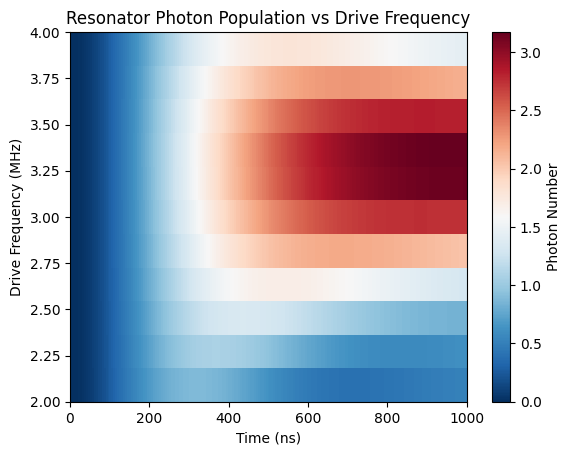

In [ ]:
y_axis = (omega_ds - omega_r)/chi
# y_axis = omega_ds

plt.imshow(resonator_populations[0,:,:], origin='lower', interpolation='none', aspect='auto', cmap='RdBu_r', extent=[times[0], times[-1], y_axis[0], y_axis[-1]])
plt.colorbar(label='Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Frequency (MHz)')
plt.title('Resonator Photon Population vs Drive Frequency')
plt.show()

In [1190]:
num_resonator_levels = 8
num_qubit_levels = 3
num_qubits = 2

a_qs = []
for i in range(num_qubits):
    identity_list = [qt.qeye(num_qubit_levels) for j in range(num_qubits)]
    identity_list[i] = qt.destroy(num_qubit_levels)
    a_qs.append(qt.tensor([qt.qeye(num_resonator_levels)] + identity_list))

qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor([qt.destroy(num_resonator_levels)] + [qt.qeye(num_qubit_levels) for i in range(num_qubits)])


omega_q1 = 4.0 * 2 * np.pi
omega_q2 = 3.0 * 2 * np.pi
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

# qubit 1 resonator coupling
g = 0.1 * 2 * np.pi

# qubit 1 - qubit 2 coupling
g_12 = 0.01 * 2 * np.pi

# assume same for both qubits
U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi

# got this from the chevron
omega_d = omega_r + 0.00328 * 2 * np.pi




times = np.linspace(0, 2000, 501)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 0])  # ground state
psi_e1 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 1, 0])  # excited state
psi_e2 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 1])  # excited state
psi_eplus = 1/np.sqrt(2)*(psi_e1 + psi_e2)  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_qs[0],
    np.sqrt(Gamma_1) * a_qs[1],
    np.sqrt(Gamma_phi) * a_qs[0].dag()*a_qs[0],
    np.sqrt(Gamma_phi) * a_qs[1].dag()*a_qs[1]
]  # collapse operators



H = (omega_q1 - omega_d) * a_qs[0].dag()*a_qs[0] + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_qs[0].dag()*a_qs[0] * (a_qs[0].dag()*a_qs[0] - 1)
H += (omega_q2 - omega_d) * a_qs[1].dag()*a_qs[1] + U/2*a_qs[1].dag()*a_qs[1] * (a_qs[1].dag()*a_qs[1] - 1) + g_12/2*(a_qs[0].dag()*a_qs[1] + a_qs[1].dag()*a_qs[0])
H += g*(a_qs[0].dag()*a_r + a_r.dag()*a_qs[0])
H += Omega*(a_r + a_r.dag())


result_g = qt.mesolve(H, psi_g, times, c_ops)
result_e1 = qt.mesolve(H, psi_e1, times, c_ops)
result_e2 = qt.mesolve(H, psi_e2, times, c_ops)
result_eplus = qt.mesolve(H, psi_eplus, times, c_ops)

results = [result_g, result_e1, result_e2, result_eplus]
detuned_results = results.copy()


expected photon number: 4.0
chi: 1.0 MHz


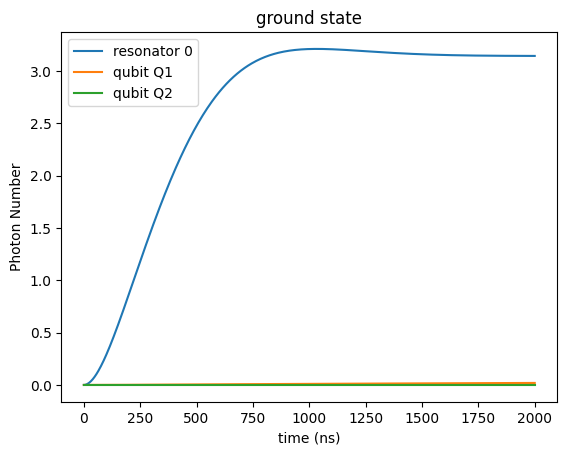

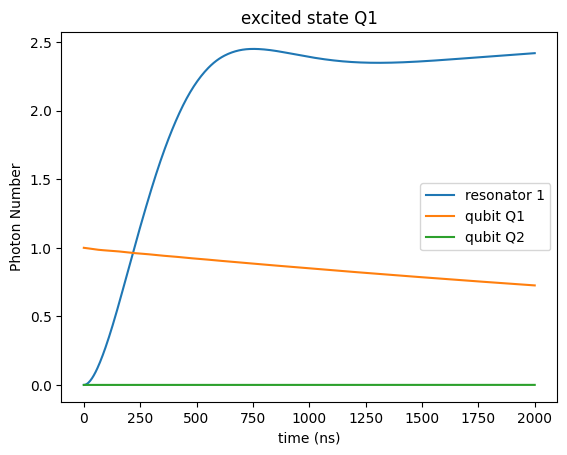

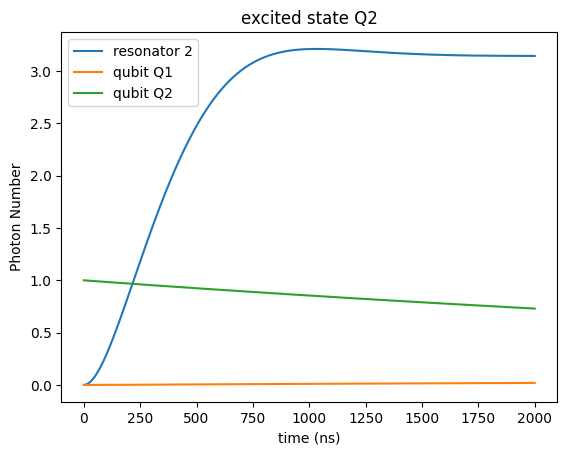

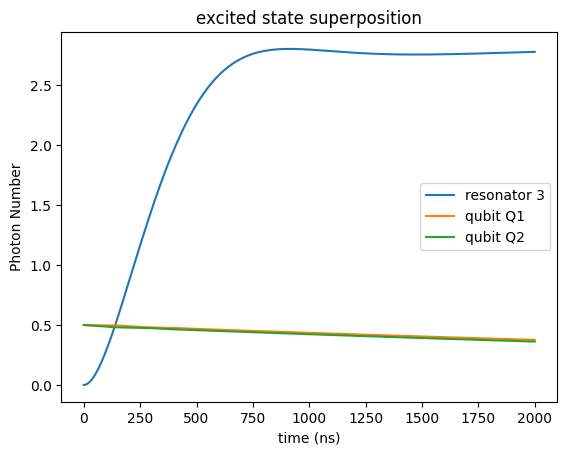

In [1191]:
results = detuned_results
titles = ['ground state', 'excited state Q1', 'excited state Q2', 'excited state superposition']

for i in range(len(results)):
    result = results[i]
    title = titles[i]
    
    photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result.states])
    qubit_population_1 = np.array([qt.expect(a_qs[0].dag()*a_qs[0], state) for state in result.states])
    qubit_population_2 = np.array([qt.expect(a_qs[1].dag()*a_qs[1], state) for state in result.states])
    plt.plot(times, photon_number_expectation, label=f'resonator {i}')
    plt.plot(times, qubit_population_1, label=f'qubit Q1')
    plt.plot(times, qubit_population_2, label=f'qubit Q2')


    plt.xlabel('time (ns)')
    plt.ylabel('Photon Number')
    plt.legend()

    plt.title(title)
    plt.show()

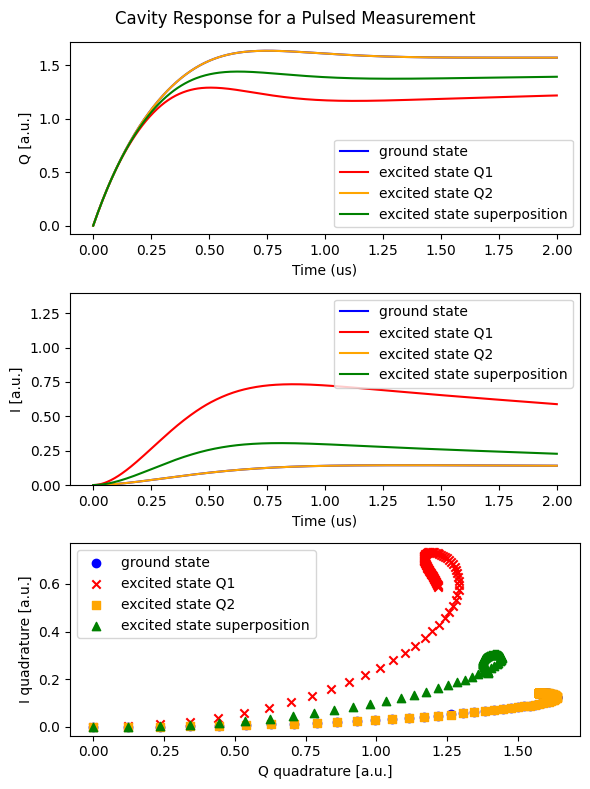

<Figure size 640x480 with 0 Axes>

In [1192]:
# plot both ground and excited states together

labels = ['ground state', 'excited state Q1', 'excited state Q2', 'excited state superposition']
colors = ['blue', 'red', 'orange', 'green']
markers = ['o', 'x', 's', '^']

fig, ax = plt.subplots(3, 1, figsize=(6, 8))


for i in range(len(results)):
    result = results[i] 
    label = labels[i]
    color = colors[i]
    marker = markers[i]

        

    a_expectation = np.array([qt.expect(a_r, state) for state in result.states])


    I = np.abs(np.real(a_expectation))
    Q = np.abs(np.imag(a_expectation))

    times = np.array(result.times)/1000
    ax[0].plot(times, Q, label=label, color=color)
    

    ax[1].plot(times, I, label=label, color=color)
   

    ax[2].scatter(Q[::5], I[::5], label=label, marker=marker, color=color)
    

ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

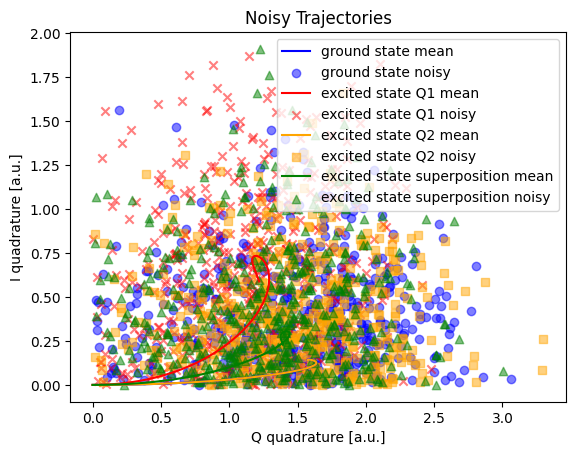

In [1193]:
### simulate single shot readout

# assume standard deviation doesn't change with time
sigma = 0.5


shots = 1000

singleshot_points = np.zeros((shots, len(results)), dtype=complex)

for k in range(shots):

    a_expectations = np.zeros((len(results), len(result_g.states)), dtype=complex)
    a_expectations_noisy = np.zeros((len(results), len(result_g.states)), dtype=complex)

    for j in range(len(results)):
        result = results[j]
        color = colors[j]
        marker = markers[j]
        title = titles[j]

        for i in range(len(result.states)):
            # get the state
            state = result.states[i]
            # get the expectation value
            a_expectation = qt.expect(a_r, state)
            a_expectations[j, i] = a_expectation
            # add noise
            a_expectations_noisy[j, i] = a_expectation + np.random.normal(0, sigma) + 1j * np.random.normal(0, sigma)
            # plot the result


        average = np.mean(a_expectations_noisy[j,:])



        if k == 0:
            plt.plot(np.abs(a_expectations[j,:].imag), np.abs(a_expectations[j,:].real), color=color, label=f'{title} mean')
            plt.scatter(np.abs(a_expectations_noisy[j,:].imag), np.abs(a_expectations_noisy[j,:].real), color=color, marker=marker, alpha=0.5, label=f'{title} noisy')

            # plt.scatter(np.imag(average), np.real(average), color='green', label='average')

    if k == 0:
        plt.xlabel('Q quadrature [a.u.]')
        plt.ylabel('I quadrature [a.u.]')
        plt.legend()
        plt.title('Noisy Trajectories')
        plt.show()

    singleshot_points[k,:] = np.mean(a_expectations_noisy, axis=1)



    

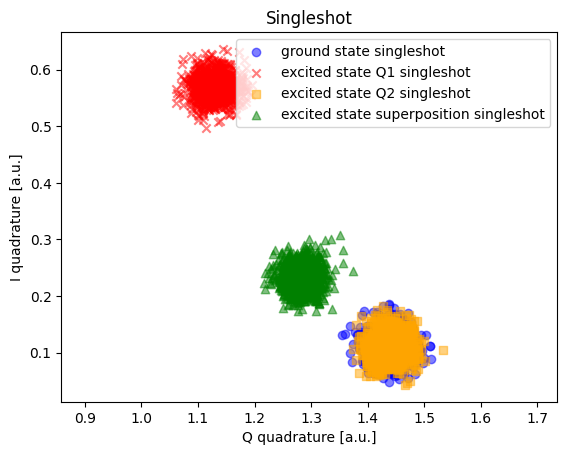

In [1194]:
for i in range(len(results)):
    IQ = singleshot_points[:,i]
    plt.scatter(np.abs(IQ.imag), np.abs(IQ.real), color=colors[i], marker=markers[i], alpha=0.5, label=f'{titles[i]} singleshot')

plt.xlabel('Q quadrature [a.u.]')
plt.ylabel('I quadrature [a.u.]')
plt.legend()
plt.title('Singleshot')
plt.axis('equal')
plt.show()

In [1195]:
### check purity of density matrix

for j in range(len(results)):
    result = results[j]
    color = colors[j]
    marker = markers[j]
    title = titles[j]

    print(f'{title} purity:')

    state = result.states[-1]
    state

    rho_r = state.ptrace(0)
    rho_q1 = state.ptrace(1)
    rho_q2 = state.ptrace(2)

    print(rho_r.purity())
    print(rho_q1.purity())
    print(rho_q2.purity())

    print()

ground state purity:
0.7153937039599563
0.9685100962138217
0.9999944773695162

excited state Q1 purity:
0.6163683784190198
0.5681318819040235
0.9994731408437828

excited state Q2 purity:
0.7151873335433716
0.9680220972594521
0.6059219642465457

excited state superposition purity:
0.5243905233150359
0.5310430113258011
0.5383403678375166



#### 3.2.2 Resonant Qubits
Operate both qubits at 4 GHz

In [ ]:
num_resonator_levels = 8
num_qubit_levels = 2
num_qubits = 2

a_qs = []
for i in range(num_qubits):
    identity_list = [qt.qeye(num_qubit_levels) for j in range(num_qubits)]
    identity_list[i] = qt.destroy(num_qubit_levels)
    a_qs.append(qt.tensor([qt.qeye(num_resonator_levels)] + identity_list))

qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor([qt.destroy(num_resonator_levels)] + [qt.qeye(num_qubit_levels) for i in range(num_qubits)])


omega_q1 = 4.0 * 2 * np.pi
omega_q2 = omega_q1
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

# qubit 1 resonator coupling
g = 0.1 * 2 * np.pi

# qubit 1 - qubit 2 coupling
g_12 = 0.01 * 2 * np.pi

# assume same for both qubits
U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi




times = np.linspace(0, 1000, 201)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 0])  # ground state
psi_e1 = qt.basis([num_resonator_levels, num_qubit_levels,num_qubit_levels], [0, 1, 0])  # excited state
psi_e2 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 1])  # excited state
psi_eplus = 1/np.sqrt(2)*(psi_e1 + psi_e2)  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_qs[0],
    np.sqrt(Gamma_1) * a_qs[1],
    np.sqrt(Gamma_phi) * a_qs[0].dag()*a_qs[0],
    np.sqrt(Gamma_phi) * a_qs[1].dag()*a_qs[1]
]  # collapse operators


omega_ds = np.linspace(omega_r + 2*chi, omega_r + 4*chi, 11)
resonator_populations = np.zeros((4, len(omega_ds), len(times)))

for i in range(len(omega_ds)):

    omega_d = omega_ds[i]
    print(f'{i}: {omega_d/2/np.pi*1e3} MHz')



    H = (omega_q1 - omega_d) * a_qs[0].dag()*a_qs[0] + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_qs[0].dag()*a_qs[0] * (a_qs[0].dag()*a_qs[0] - 1)
    H += (omega_q2 - omega_d) * a_qs[1].dag()*a_qs[1] + U/2*a_qs[1].dag()*a_qs[1] * (a_qs[1].dag()*a_qs[1] - 1) + g_12/2*(a_qs[0].dag()*a_qs[1] + a_qs[1].dag()*a_qs[0])
    H += g*(a_qs[0].dag()*a_r + a_r.dag()*a_qs[0])
    H += Omega*(a_r + a_r.dag())


    result_g = qt.mesolve(H, psi_g, times, c_ops)
    # result_e1 = qt.mesolve(H, psi_e1, times, c_ops)
    # result_e2 = qt.mesolve(H, psi_e2, times, c_ops)
    # result_eplus = qt.mesolve(H, psi_eplus, times, c_ops)

    resonator_populations[0,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_g.states])
    # resonator_populations[1,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e1.states])
    # resonator_populations[2,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_e2.states])
    # resonator_populations[3,i,:] = np.array([qt.expect(a_r.dag()*a_r, state) for state in result_eplus.states])



expected photon number: 4.0
chi: 1.0 MHz
0: 7002.0 MHz
1: 7002.2 MHz
2: 7002.4 MHz
3: 7002.6 MHz
4: 7002.799999999999 MHz
5: 7003.0 MHz
6: 7003.2 MHz
7: 7003.4 MHz
8: 7003.6 MHz
9: 7003.799999999999 MHz
10: 7004.0 MHz


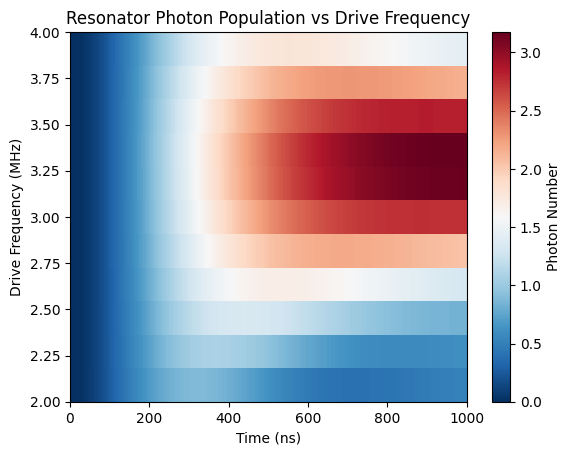

In [ ]:
y_axis = (omega_ds - omega_r)/chi
# y_axis = omega_ds

plt.imshow(resonator_populations[0,:,:], origin='lower', interpolation='none', aspect='auto', cmap='RdBu_r', extent=[times[0], times[-1], y_axis[0], y_axis[-1]])
plt.colorbar(label='Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Frequency (MHz)')
plt.title('Resonator Photon Population vs Drive Frequency')
plt.show()

In [ ]:
num_resonator_levels = 8
num_qubit_levels = 3
num_qubits = 2

a_qs = []
for i in range(num_qubits):
    identity_list = [qt.qeye(num_qubit_levels) for j in range(num_qubits)]
    identity_list[i] = qt.destroy(num_qubit_levels)
    a_qs.append(qt.tensor([qt.qeye(num_resonator_levels)] + identity_list))

qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor([qt.destroy(num_resonator_levels)] + [qt.qeye(num_qubit_levels) for i in range(num_qubits)])


omega_q1 = 4.0 * 2 * np.pi
omega_q2 = omega_q1
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

# qubit 1 resonator coupling
g = 0.1 * 2 * np.pi

# qubit 1 - qubit 2 coupling
g_12 = 0.01 * 2 * np.pi
# g_12 = 0.001 * 2 * np.pi

# assume same for both qubits
U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi

# got this from the chevron
omega_d = omega_r + 0.00328 * 2 * np.pi




times = np.linspace(0, 2000, 501)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 0])  # ground state
psi_e1 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 1, 0])  # excited state
psi_e2 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 1])  # excited state
psi_eplus = 1/np.sqrt(2)*(psi_e1 + psi_e2)  # excited state

c_ops = [
    np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_qs[0],
    np.sqrt(Gamma_1) * a_qs[1],
    np.sqrt(Gamma_phi) * a_qs[0].dag()*a_qs[0],
    np.sqrt(Gamma_phi) * a_qs[1].dag()*a_qs[1]
]  # collapse operators



H = (omega_q1 - omega_d) * a_qs[0].dag()*a_qs[0] + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_qs[0].dag()*a_qs[0] * (a_qs[0].dag()*a_qs[0] - 1)
H += (omega_q2 - omega_d) * a_qs[1].dag()*a_qs[1] + U/2*a_qs[1].dag()*a_qs[1] * (a_qs[1].dag()*a_qs[1] - 1) + g_12/2*(a_qs[0].dag()*a_qs[1] + a_qs[1].dag()*a_qs[0])
H += g*(a_qs[0].dag()*a_r + a_r.dag()*a_qs[0])
H += Omega*(a_r + a_r.dag())


result_g = qt.mesolve(H, psi_g, times, c_ops)
result_e1 = qt.mesolve(H, psi_e1, times, c_ops)
result_e2 = qt.mesolve(H, psi_e2, times, c_ops)
result_eplus = qt.mesolve(H, psi_eplus, times, c_ops)

results = [result_g, result_e1, result_e2, result_eplus]
resonant_results = results.copy()

expected photon number: 4.0
chi: 1.0 MHz


In [1186]:
resonant_results = results.copy()

In [1189]:
resonant_results[0].states[10]

Quantum object: dims=[[8, 3, 3], [8, 3, 3]], shape=(72, 72), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.45800621e-01-1.33069188e-19j  8.88751107e-06+1.81776202e-05j
  -3.81442344e-08-3.44488713e-08j ... -1.82667537e-13+1.95476459e-14j
   5.39898442e-13+6.53309972e-13j -2.34302285e-10+2.39882846e-10j]
 [ 8.88751107e-06-1.81776202e-05j  3.31371467e-07+7.36210705e-22j
  -3.04086099e-13+6.03709183e-12j ... -2.40759315e-17-4.49301514e-18j
   8.44797690e-18-6.33135215e-18j  2.88459360e-15+2.98659911e-15j]
 [-3.81442344e-08+3.44488713e-08j -3.04086099e-13-6.03709183e-12j
   2.16653137e-15-5.03419358e-28j ... -4.17458027e-21-4.56143975e-21j
  -4.96358406e-23-7.35740591e-23j  2.55738284e-20-2.33351415e-20j]
 ...
 [-1.82667537e-13-1.95476459e-14j -2.40759315e-17+4.49301514e-18j
  -4.17458027e-21+4.56143975e-21j ...  3.50361887e-25+5.49885525e-39j
  -9.10057714e-28+3.57246800e-28j -2.12544277e-25-3.03826910e-25j]
 [ 5.39898442e-13-6.53309972e-13j  8.44797690e-18+6.33135215e-18j
  -4.9

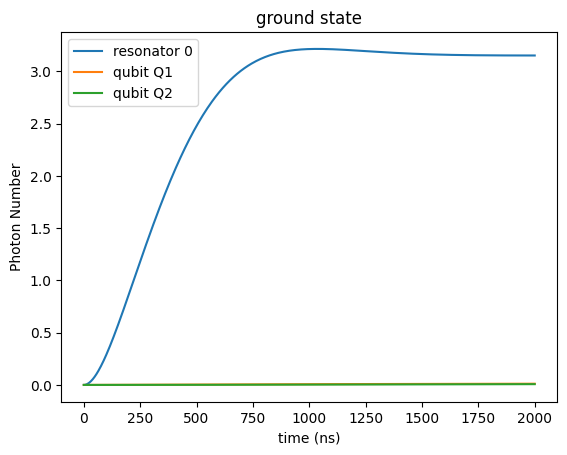

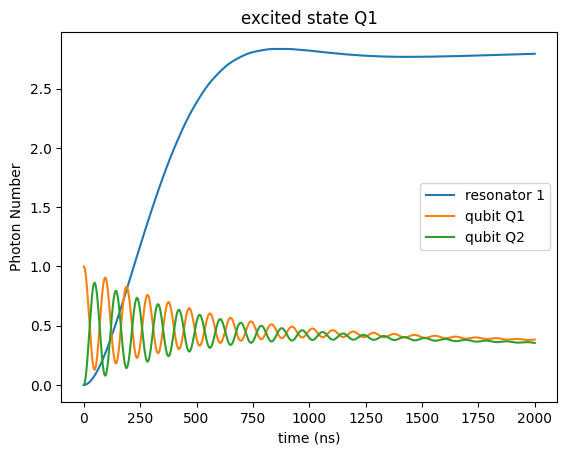

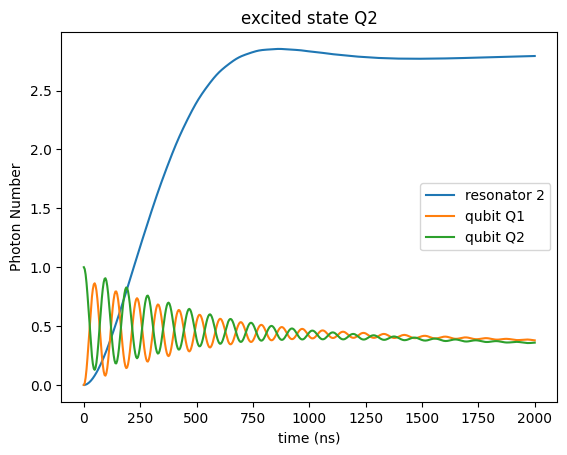

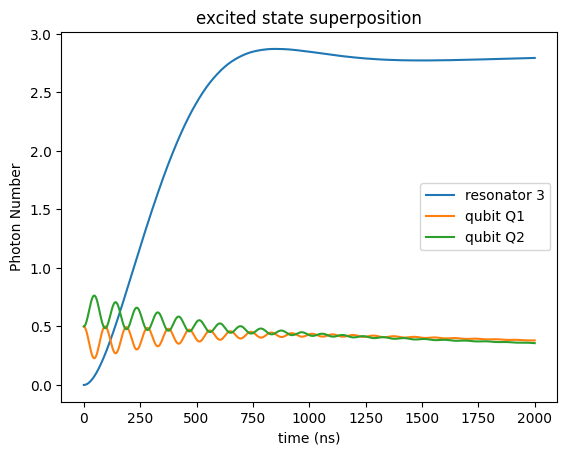

In [ ]:
results = resonant_results
titles = ['ground state', 'excited state Q1', 'excited state Q2', 'excited state superposition']

for i in range(len(results)):
    result = results[i]
    title = titles[i]
    
    photon_number_expectation = np.array([qt.expect(a_r.dag()*a_r, state) for state in result.states])
    qubit_population_1 = np.array([qt.expect(a_qs[0].dag()*a_qs[0], state) for state in result.states])
    qubit_population_2 = np.array([qt.expect(a_qs[1].dag()*a_qs[1], state) for state in result.states])
    plt.plot(times, photon_number_expectation, label=f'resonator {i}')
    plt.plot(times, qubit_population_1, label=f'qubit Q1')
    plt.plot(times, qubit_population_2, label=f'qubit Q2')


    plt.xlabel('time (ns)')
    plt.ylabel('Photon Number')
    plt.legend()

    plt.title(title)
    plt.show()

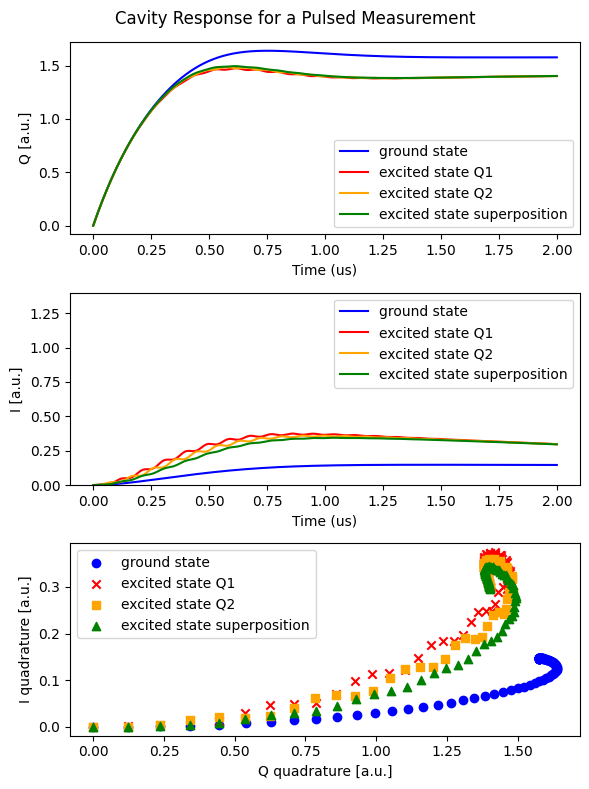

<Figure size 640x480 with 0 Axes>

In [1166]:
# plot both ground and excited states together

labels = ['ground state', 'excited state Q1', 'excited state Q2', 'excited state superposition']
colors = ['blue', 'red', 'orange', 'green']
markers = ['o', 'x', 's', '^']

fig, ax = plt.subplots(3, 1, figsize=(6, 8))


for i in range(len(results)):
    result = results[i] 
    label = labels[i]
    color = colors[i]
    marker = markers[i]

        

    a_expectation = np.array([qt.expect(a_r, state) for state in result.states])


    I = np.abs(np.real(a_expectation))
    Q = np.abs(np.imag(a_expectation))

    times = np.array(result.times)/1000
    ax[0].plot(times, Q, label=label, color=color)
    

    ax[1].plot(times, I, label=label, color=color)
   

    ax[2].scatter(Q[::5], I[::5], label=label, marker=marker, color=color)
    

ax[0].set_xlabel("Time (us)")
ax[0].set_ylabel("Q [a.u.]")
ax[0].legend()

ax[1].legend()
ax[1].set_xlabel("Time (us)")
ax[1].set_ylabel("I [a.u.]")
ax[1].set_ylim(0, 1.4)

ax[2].legend()
ax[2].set_xlabel('Q quadrature [a.u.]')
ax[2].set_ylabel('I quadrature [a.u.]')

fig.suptitle("Cavity Response for a Pulsed Measurement")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

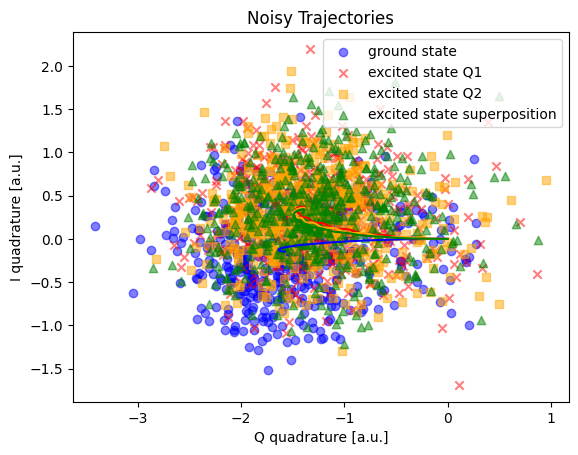

In [1169]:
### simulate single shot readout

# assume standard deviation doesn't change with time
sigma = 0.5


shots = 1000

singleshot_points = np.zeros((shots, len(results)), dtype=complex)

for k in range(shots):

    a_expectations = np.zeros((len(results), len(result_g.states)), dtype=complex)
    a_expectations_noisy = np.zeros((len(results), len(result_g.states)), dtype=complex)

    for j in range(len(results)):
        result = results[j]
        color = colors[j]
        marker = markers[j]
        title = titles[j]

        for i in range(len(result.states)):
            # get the state
            state = result.states[i]
            # get the expectation value
            a_expectation = qt.expect(a_r, state)
            a_expectations[j, i] = a_expectation
            # add noise
            a_expectations_noisy[j, i] = a_expectation + np.random.normal(0, sigma) + 1j * np.random.normal(0, sigma)
            # plot the result


        average = np.mean(a_expectations_noisy[j,:])



        if k == 0:
            plt.plot(a_expectations[j,:].imag, a_expectations[j,:].real, color=color)
            plt.scatter(a_expectations_noisy[j,:].imag, a_expectations_noisy[j,:].real, color=color, marker=marker, alpha=0.5, label=f'{title}')

            # plt.scatter(np.imag(average), np.real(average), color='green', label='average')

    if k == 0:
        plt.xlabel('Q quadrature [a.u.]')
        plt.ylabel('I quadrature [a.u.]')
        plt.legend()
        plt.title('Noisy Trajectories')
        plt.show()

    singleshot_points[k,:] = np.mean(a_expectations_noisy, axis=1)



    

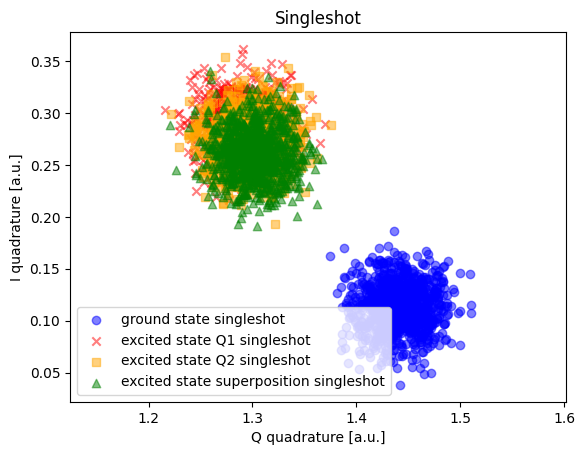

In [1170]:
for i in range(len(results)):
    IQ = singleshot_points[:,i]
    plt.scatter(np.abs(IQ.imag), np.abs(IQ.real), color=colors[i], marker=markers[i], alpha=0.5, label=f'{titles[i]} singleshot')

plt.xlabel('Q quadrature [a.u.]')
plt.ylabel('I quadrature [a.u.]')
plt.legend()
plt.title('Singleshot')
plt.axis('equal')
plt.show()

In [1185]:
### check purity of density matrix

for j in range(len(results)):
    result = results[j]
    color = colors[j]
    marker = markers[j]
    title = titles[j]

    print(f'{title} purity:')

    state = result.states[-1]
    state

    rho_r = state.ptrace(0)
    rho_q1 = state.ptrace(1)
    rho_q2 = state.ptrace(2)

    print(rho_r.purity())
    print(rho_q1.purity())
    print(rho_q2.purity())

    print()

ground state purity:
0.7215974552999342
0.9824560825026812
0.9854500754896306

excited state Q1 purity:
0.6112095477008437
0.526720568183354
0.542488824379827

excited state Q2 purity:
0.6111650090854971
0.52883225035824
0.5395836634670517

excited state superposition purity:
0.6111689005468892
0.5277387285433572
0.5407811402923032



### 3.3 Stochastic Master Equation solver
Try to capture projective measurement

In [7]:
num_resonator_levels = 8
num_qubit_levels = 3
num_qubits = 2

a_qs = []
for i in range(num_qubits):
    identity_list = [qt.qeye(num_qubit_levels) for j in range(num_qubits)]
    identity_list[i] = qt.destroy(num_qubit_levels)
    a_qs.append(qt.tensor([qt.qeye(num_resonator_levels)] + identity_list))

qt.tensor(qt.qeye(num_resonator_levels), qt.destroy(num_qubit_levels))
a_r = qt.tensor([qt.destroy(num_resonator_levels)] + [qt.qeye(num_qubit_levels) for i in range(num_qubits)])


omega_q1 = 4.0 * 2 * np.pi
omega_q2 = omega_q1
omega_r = 7.0 * 2 * np.pi  # frequency in GHz

# qubit 1 resonator coupling
g = 0.1 * 2 * np.pi

# qubit 1 - qubit 2 coupling
g_12 = 0.01 * 2 * np.pi
# g_12 = 0.001 * 2 * np.pi

# assume same for both qubits
U = -0.2 * 2 * np.pi
kappa = 0.001 * 2*np.pi # decay rate

T1 = 40000 # (ns)
Gamma_1 = 2*np.pi/T1 # T1 decay

T2 = 2000 # (ns)
Gamma_phi = 2*np.pi/T2 - Gamma_1/2


Omega = 0.0002 * 2 * np.pi  # Rabi frequency
Omega = 0.001 * 2 * np.pi  # Rabi frequency

print(f'expected photon number: {4*(Omega/kappa)**2}')


Delta = omega_r - omega_q1

E_c = 200 # MHz
chi = g**2/Delta * E_c/(E_c + Delta)
chi = 0.001 * 2 * np.pi

print(f'chi: {chi/2/np.pi*1e3} MHz')

omega_d = omega_r - chi

# got this from the chevron
omega_d = omega_r + 0.00328 * 2 * np.pi




times = np.linspace(0, 1000, 101)  # time points

psi_g = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 0])  # ground state
psi_e1 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 1, 0])  # excited state
psi_e2 = qt.basis([num_resonator_levels, num_qubit_levels, num_qubit_levels], [0, 0, 1])  # excited state
psi_eplus = 1/np.sqrt(2)*(psi_e1 + psi_e2)  # excited state

c_ops = [
    # np.sqrt(kappa) * a_r, 
    np.sqrt(Gamma_1) * a_qs[0],
    np.sqrt(Gamma_1) * a_qs[1],
    np.sqrt(Gamma_phi) * a_qs[0].dag()*a_qs[0],
    np.sqrt(Gamma_phi) * a_qs[1].dag()*a_qs[1]
]  # collapse operators

sc_ops = [
    np.sqrt(kappa) * a_r, 
]


H = (omega_q1 - omega_d) * a_qs[0].dag()*a_qs[0] + (omega_r - omega_d) * a_r.dag() * a_r + U/2*a_qs[0].dag()*a_qs[0] * (a_qs[0].dag()*a_qs[0] - 1)
H += (omega_q2 - omega_d) * a_qs[1].dag()*a_qs[1] + U/2*a_qs[1].dag()*a_qs[1] * (a_qs[1].dag()*a_qs[1] - 1) + g_12/2*(a_qs[0].dag()*a_qs[1] + a_qs[1].dag()*a_qs[0])
H += g*(a_qs[0].dag()*a_r + a_r.dag()*a_qs[0])
H += Omega*(a_r + a_r.dag())


# Detection efficiency (0 < η ≤ 1)
eta = 0.4

# We’ll record <a_r> (complex) as our heterodyne current
# e_ops = [a_r]
e_ops = None

# Pack args for smesolve
sme_args = {
    'eta': eta,       # detection efficiency
    'phi': 0.0        # reference phase for heterodyne (ignored; both quadratures)
}

# Number of trajectories you want to average over
n_traj = 2


# Now run smesolve for each initial state
result_g     = qt.smesolve(H, psi_g, times, c_ops, sc_ops=sc_ops, 
                           heterodyne=True, ntraj=n_traj)

# result_e1    = qt.smesolve(H, psi_e1, times, c_ops, sc_ops=sc_ops, 
#                            heterodyne=True, ntraj=n_traj)

# result_e2    = qt.smesolve(H, psi_e2, times, c_ops, sc_ops=sc_ops, 
#                            heterodyne=True, ntraj=n_traj)

# result_eplus     = qt.smesolve(H, psi_eplus, times, c_ops, sc_ops=sc_ops, 
#                            heterodyne=True, ntraj=n_traj)


expected photon number: 4.0
chi: 1.0 MHz
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
100.0%. Run time: 848.24s. Est. time left: 00:00:00:00
Total run time: 1735.04s


In [12]:
samples_g = np.array([qt.expect(a_r, state) for state in result_g.states])

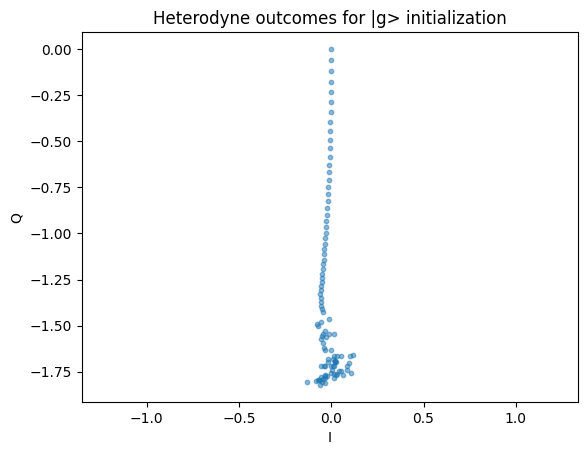

In [13]:
# pick the final time index, for example
t_idx = -1
# samples_g = hetero_g[t_idx, :]   # n_traj complex numbers

# Plot as a scatter or 2D histogram:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(samples_g.real, samples_g.imag, s=10, alpha=0.5)
plt.xlabel('I'); plt.ylabel('Q')
plt.title('Heterodyne outcomes for |g> initialization')
plt.axis('equal')
plt.show()


### Gaussian Statistics


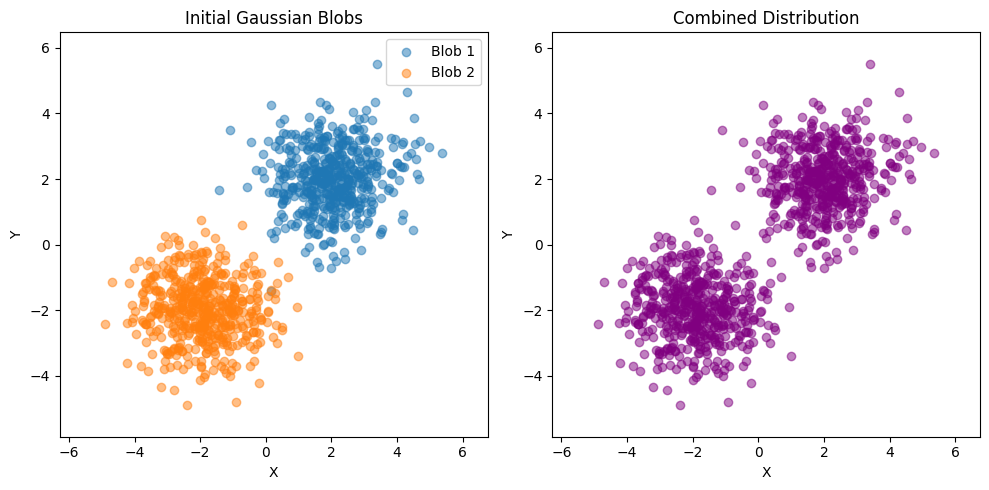

c:\Users\mattm\OneDrive\Desktop\Research\Software\venv\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


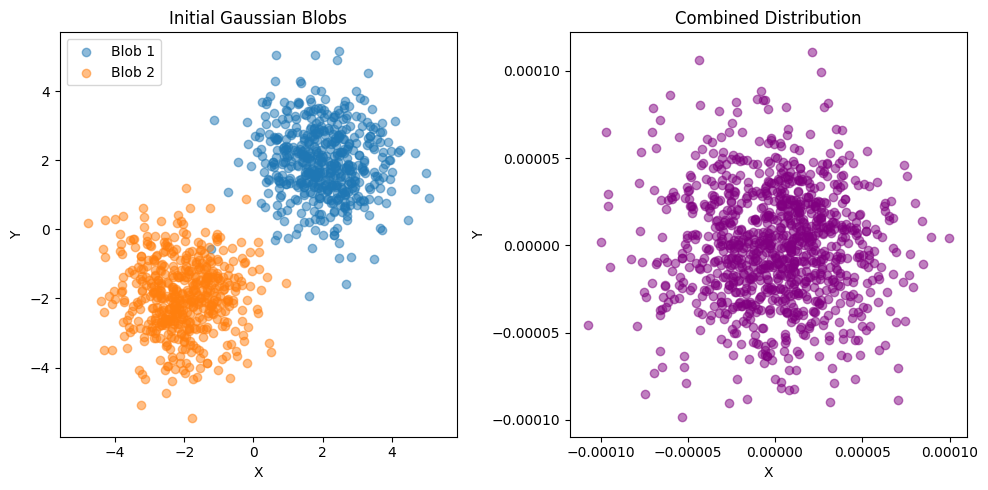

In [1178]:
# Define parameters for the two Gaussian distributions
mean1 = [2, 2]
cov1 = [[1, 0], [0, 1]]  # Circular covariance matrix

mean2 = [-2, -2]
cov2 = [[1, 0], [0, 1]]  # Circular covariance matrix

# Sample 500 points from each distribution
points1 = np.random.multivariate_normal(mean1, cov1, 500)
points2 = np.random.multivariate_normal(mean2, cov2, 500)

# Combine the points
all_points = np.vstack((points1, points2))

# Plot the initial blobs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(points1[:, 0], points1[:, 1], alpha=0.5, label="Blob 1")
plt.scatter(points2[:, 0], points2[:, 1], alpha=0.5, label="Blob 2")
plt.title("Initial Gaussian Blobs")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")

# Plot the resulting distribution
plt.subplot(1, 2, 2)
plt.scatter(all_points[:, 0], all_points[:, 1], alpha=0.5, color="purple")
plt.title("Combined Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")

plt.tight_layout()
plt.show()


shots = 1000
# Sample 500 points from each distribution

all_points = np.zeros((1000, 2), dtype=complex)

for i in range(shots):
    points1 = np.random.multivariate_normal(mean1, cov1, 500)
    points2 = np.random.multivariate_normal(mean2, cov2, 500)

    # Combine the points
    all_points[i,:] = np.mean(np.vstack((points1, points2)), axis=0)

all_points /= shots

# Plot the initial blobs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(points1[:, 0], points1[:, 1], alpha=0.5, label="Blob 1")
plt.scatter(points2[:, 0], points2[:, 1], alpha=0.5, label="Blob 2")
plt.title("Initial Gaussian Blobs")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")

# Plot the resulting distribution
plt.subplot(1, 2, 2)
plt.scatter(all_points[:, 0], all_points[:, 1], alpha=0.5, color="purple")
plt.title("Combined Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")

plt.tight_layout()
plt.show()


